<a href="https://colab.research.google.com/github/hoaian1232812/Review_Tiki_ML/blob/main/Review_Tiki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Lab_ML'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Lab_ML


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn import svm
from sklearn import metrics as m
from sklearn.model_selection import train_test_split as tts
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Đọc dữ liệu

In [ ]:
data = pd.read_excel('review.xlsx')
data.head()

,content,thank_count,comment_count,rating
0,Samsung chất lượng ổn định. nhờ đơn vị bán hàn...,0,0,5
1,NaN,0,0,5
2,"Sản phẩm nguyên seal , đóng gói cẩn thận",1,0,5
3,Sp tốt,0,0,5
4,Quá nhanh luôn,0,0,5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6612 entries, 0 to 6611
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   content        2988 non-null   object
 1   thank_count    6612 non-null   int64 
 2   comment_count  6612 non-null   int64 
 3   rating         6612 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 206.8+ KB


In [ ]:
data.isna().sum()

content          3624
thank_count         0
comment_count       0
rating              0
dtype: int64

Xem và đánh giá dữ liệu số

In [ ]:
data.describe()

,thank_count,comment_count,rating
count,6612.000000,6612.000000,6612.000000
mean,0.340139,0.080157,4.771022
std,3.434545,0.700446,0.690420
min,0.000000,0.000000,1.000000
25%,0.000000,0.000000,5.000000
50%,0.000000,0.000000,5.000000
75%,0.000000,0.000000,5.000000
max,130.000000,21.000000,5.000000


In [ ]:
num_data = data.drop(columns='content')

In [ ]:
for col in num_data.columns:
  print(col, ':', len(num_data[col].value_counts()))
  print(num_data[col].value_counts())

thank_count : 31
0      6003
1       352
2       107
3        40
4        24
5        17
6        17
11        8
7         6
8         5
9         4
10        3
12        3
14        2
55        2
71        2
19        2
20        2
16        1
62        1
47        1
126       1
130       1
111       1
39        1
17        1
29        1
15        1
13        1
27        1
18        1
Name: thank_count, dtype: int64
comment_count : 16
0     6374
1      148
2       46
3       12
4        8
5        6
6        5
7        3
20       2
9        2
10       1
21       1
19       1
13       1
12       1
8        1
Name: comment_count, dtype: int64
rating : 5
5    5678
4     646
1     120
3     116
2      52
Name: rating, dtype: int64


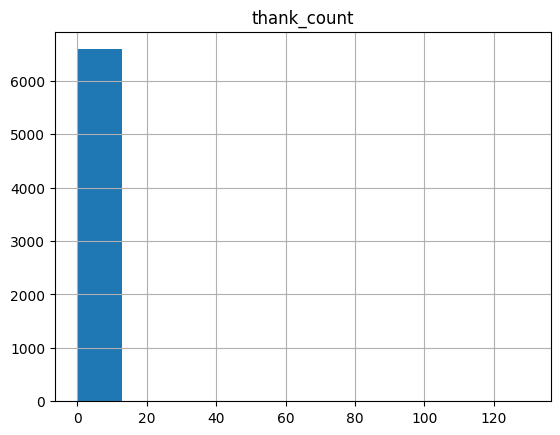

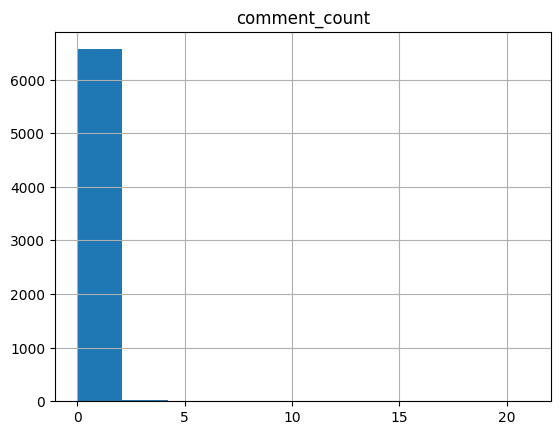

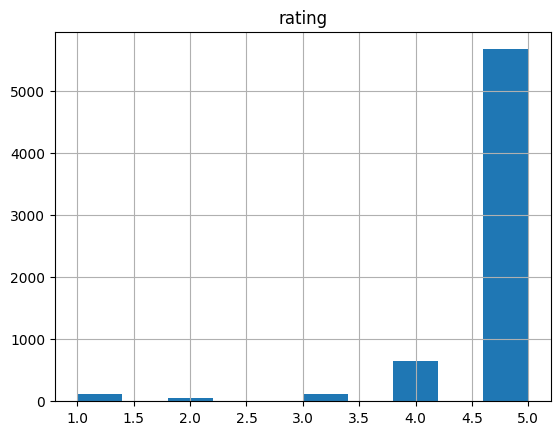

In [ ]:
for col in num_data:
    data[col].hist()
    plt.title(col)  
    plt.show()

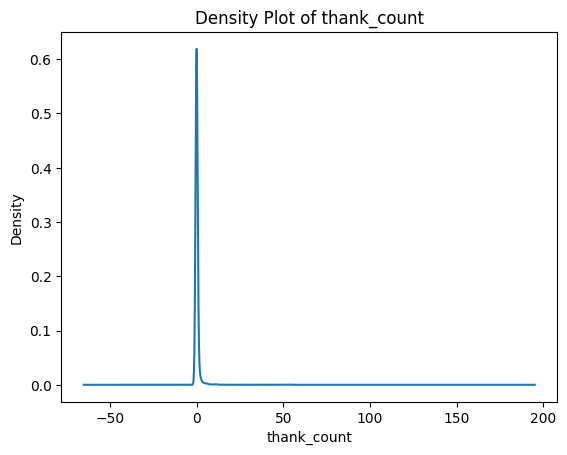

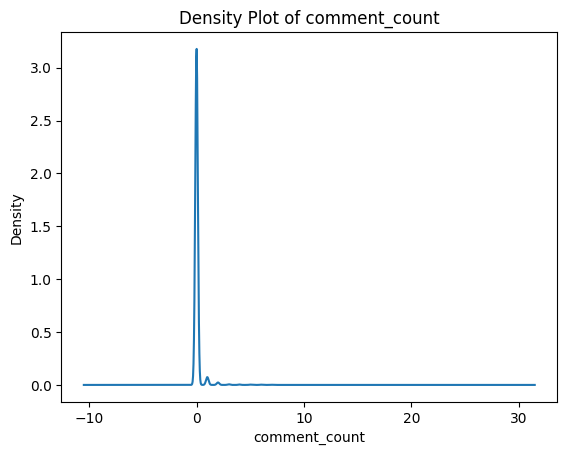

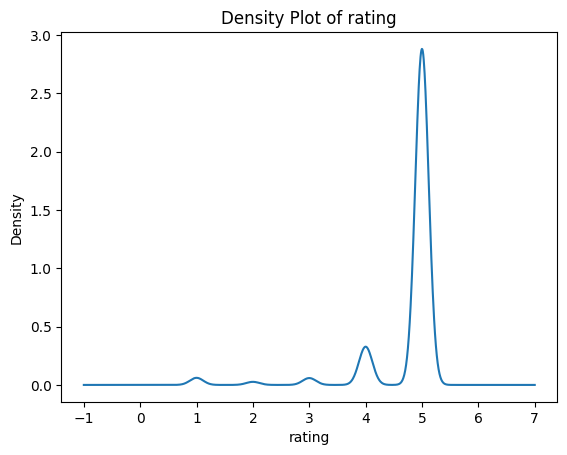

In [ ]:
for col in num_data:
    data[col].plot.density()
    plt.xlabel(col)  
    plt.ylabel('Density')
    plt.title(f'Density Plot of {col}')
    plt.show()

thank_count         Axes(0.125,0.653529;0.227941x0.226471)
comment_count    Axes(0.398529,0.653529;0.227941x0.226471)
rating           Axes(0.672059,0.653529;0.227941x0.226471)
dtype: object

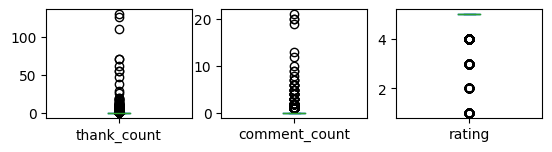

In [ ]:
num_data.plot(kind='box', subplots=True, layout=(3,3), sharex=False)

<Axes: xlabel='thank_count', ylabel='comment_count'>

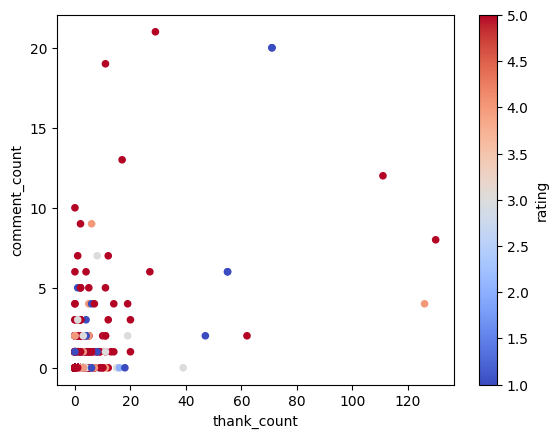

In [ ]:
num_data.plot.scatter(x='thank_count', y='comment_count', c='rating', cmap='coolwarm')

In [ ]:
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-23-4be3066975ee>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,thank_count,comment_count,rating
thank_count,1.00,0.55,-0.12
comment_count,0.55,1.00,-0.11
rating,-0.12,-0.11,1.00


<Axes: xlabel='thank_count', ylabel='comment_count'>

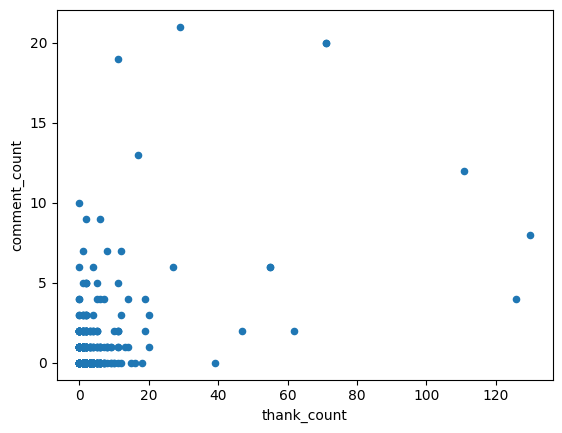

In [ ]:
num_data.plot.scatter(x='thank_count', y='comment_count')

#Tiền xử lý dữ liệu

In [ ]:
#lưu lại data
data_copy = data

In [ ]:
# Gán nhãn dữ liệu
def label_data(rating):
    if rating == 1 or rating == 2:
        return 'negative'
    elif rating == 4 or rating == 5:
        return 'positive'
    else:
        return 'neutral'

data['label'] = data['rating'].apply(label_data)

data.head()

,content,thank_count,comment_count,rating,label
0,Samsung chất lượng ổn định. nhờ đơn vị bán hàn...,0,0,5,positive
1,NaN,0,0,5,positive
2,"Sản phẩm nguyên seal , đóng gói cẩn thận",1,0,5,positive
3,Sp tốt,0,0,5,positive
4,Quá nhanh luôn,0,0,5,positive


In [ ]:
#vector hóa
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

text_data = data['content'].fillna('')

tagged_data = [TaggedDocument(words=str(text).split(), tags=[str(i)]) for i, text in enumerate(text_data)]

model = Doc2Vec(vector_size=100, min_count=2, epochs=40)

# Xây dựng từ vựng
model.build_vocab(tagged_data)

model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Chuyển đổi văn bản thành vector
document_vectors = [model.infer_vector(str(text).split()) for text in text_data]

In [ ]:
len(document_vectors)

6612

In [ ]:
df_vectors = pd.DataFrame(document_vectors, columns=[f'vector_{i}' for i in range(100)])
data = pd.concat([ df_vectors, data], axis=1)

In [ ]:
data = data.drop(columns='content')
data.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99,thank_count,comment_count,rating,label
0,-0.182833,0.141380,-0.049377,0.181669,0.142583,-0.555789,-0.083734,0.328143,-0.176523,-0.343628,...,0.475197,0.458954,-0.118038,-0.098715,-0.168929,-0.186661,0,0,5,positive
1,0.000164,0.001781,0.004737,0.004850,-0.002421,0.000753,0.000990,0.000122,-0.003704,-0.001757,...,-0.004474,-0.003027,0.004395,-0.004911,-0.001672,0.003667,0,0,5,positive
2,-0.118009,-0.056291,-0.002760,-0.051372,0.150137,-0.308718,0.046661,0.296335,-0.049179,-0.166876,...,0.185508,0.233559,0.097963,0.049326,0.008456,0.086149,1,0,5,positive
3,-0.014331,-0.012309,-0.084609,0.029722,-0.008318,-0.130918,0.007191,0.194366,-0.113408,-0.094812,...,0.135999,0.078666,0.086601,-0.057823,-0.039210,0.025287,0,0,5,positive
4,-0.165637,0.100587,-0.066997,0.081069,0.024358,-0.106517,-0.000400,0.165448,-0.100007,-0.202516,...,0.151252,0.210098,0.140945,-0.017802,-0.140791,-0.026084,0,0,5,positive


In [ ]:
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(output_distribution='normal')
data['comment_count'] = transformer.fit_transform(data[['comment_count']])
data['thank_count'] = transformer.fit_transform(data[['thank_count']])

<Axes: ylabel='Frequency'>

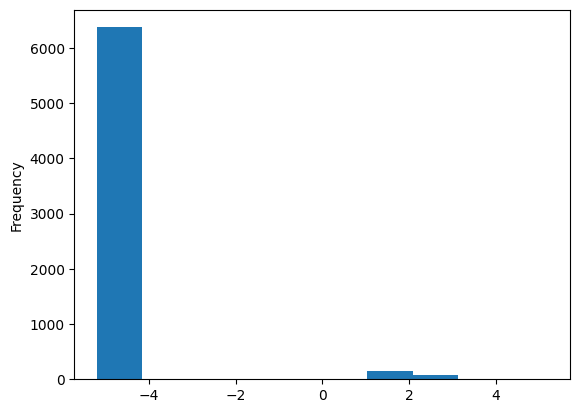

In [ ]:
data['comment_count'].plot.hist()

<Axes: xlabel='thank_count', ylabel='comment_count'>

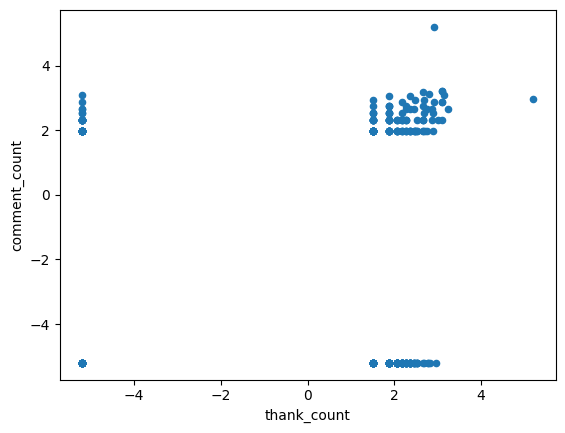

In [ ]:
data.plot.scatter(x='thank_count', y='comment_count')

In [ ]:
data = pd.read_csv('review_clean_data.csv')
data.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_94,vector_95,vector_96,vector_97,vector_98,vector_99,thank_count,comment_count,rating,label
0,-0.182833,0.141380,-0.049377,0.181669,0.142583,-0.555789,-0.083735,0.328143,-0.176523,-0.343628,...,0.475197,0.458954,-0.118038,-0.098715,-0.168929,-0.186661,0,0,5,positive
1,0.000164,0.001781,0.004737,0.004850,-0.002421,0.000753,0.000990,0.000122,-0.003704,-0.001757,...,-0.004474,-0.003027,0.004395,-0.004911,-0.001672,0.003667,0,0,5,positive
2,-0.118009,-0.056291,-0.002760,-0.051372,0.150137,-0.308718,0.046661,0.296335,-0.049179,-0.166876,...,0.185508,0.233559,0.097963,0.049326,0.008456,0.086149,1,0,5,positive
3,-0.014331,-0.012309,-0.084609,0.029722,-0.008318,-0.130918,0.007191,0.194366,-0.113408,-0.094812,...,0.135999,0.078666,0.086601,-0.057823,-0.039210,0.025287,0,0,5,positive
4,-0.165637,0.100587,-0.066997,0.081069,0.024358,-0.106517,-0.000400,0.165448,-0.100007,-0.202516,...,0.151252,0.210098,0.140945,-0.017802,-0.140791,-0.026084,0,0,5,positive


In [ ]:
x = data.drop(columns='label')
y = data[['label']]

<Axes: >

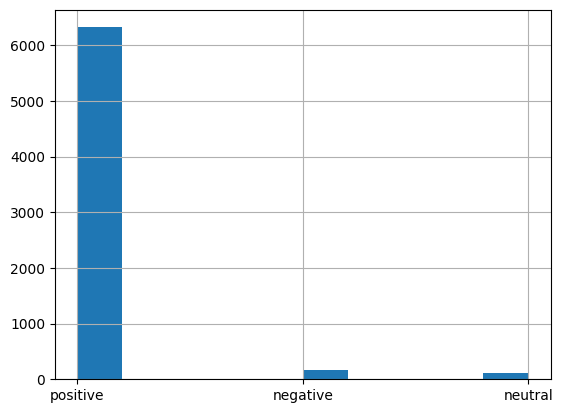

In [ ]:
data['label'].hist()

([<matplotlib.patches.Wedge at 0x7fcaef24f400>,
 [Text(-1.0897173772091324, 0.1500534498385476, 'positive'),
  Text(1.0797965519360648, -0.2098556799969583, 'negative'),
  Text(1.0983296687609465, -0.06059652398834421, 'netural')],
 [Text(-0.5943912966595267, 0.0818473362755714, '95.6%'),
  Text(0.5889799374196716, -0.11446673454379543, '2.6%'),
  Text(0.5990889102332434, -0.03305264944818775, '1.8%')])

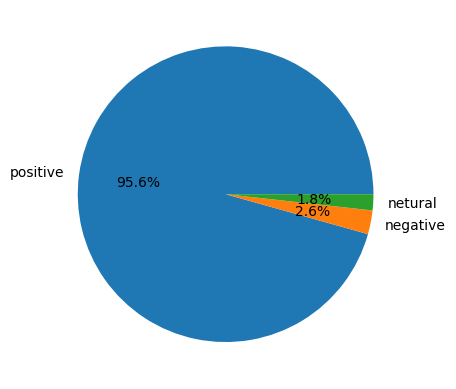

In [ ]:
plt.pie(y.value_counts().values, labels = ['positive', 'negative', 'netural'], autopct = '%1.1f%%') 

In [ ]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN(sampling_strategy='not majority', n_neighbors=5)
x_train_new, y_train_new = adasyn.fit_resample(x_train, y_train)
print(y_train_new.value_counts())
print(y_train.value_counts())

label   
negative    5061
neutral     5059
positive    5059
dtype: int64
label   
positive    5059
negative     145
neutral       85
dtype: int64


In [ ]:
#lưu lại data đã được xử lý vào driver
data.to_csv('/content/gdrive/MyDrive/Lab_ML/review_clean_data.csv', index=False)

#Xây dưng model

In [ ]:
def build_model(clf, name_clf, x_train, y_train, x_test, y_test):
  clf.fit(x_train, y_train)
  y_predict = clf.predict(x_test)
  accuracy = m.accuracy_score(y_test, y_predict)
  precision = m.precision_score(y_test, y_predict,average='macro', pos_label='positive')
  recall = m.recall_score(y_test, y_predict,average='macro', pos_label='positive')
  f1 = m.f1_score(y_test, y_predict,average='macro', pos_label='positive')
  print(m.classification_report(y_test, y_predict))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  
  # Vẽ confusion matrix
  sns.heatmap(m.confusion_matrix(y_test, y_predict), annot=True, fmt='d', cmap='Blues', ax=ax1)
  ax1.set_xticklabels(np.unique(y_test))
  ax1.set_yticklabels(np.unique(y_test))
  ax1.set_xlabel('Predicted')
  ax1.set_ylabel('True')
  ax1.set_title('Confusion Matrix')

  # Vẽ biểu đồ cột
  ax2.bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])
  ax2.set_ylim(0, 1)
  ax2.set_xlabel('Metrics')
  ax2.set_ylabel('Score')
  ax2.set_title('Evaluation Metrics')

  plt.tight_layout()
  plt.show()

  return [name_clf, round(accuracy,2), round(precision,2), round(recall,2), round(f1,2)]


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       1.00      1.00      1.00        31
    positive       1.00      1.00      1.00      1265

    accuracy                           1.00      1323
   macro avg       1.00      1.00      1.00      1323
weighted avg       1.00      1.00      1.00      1323



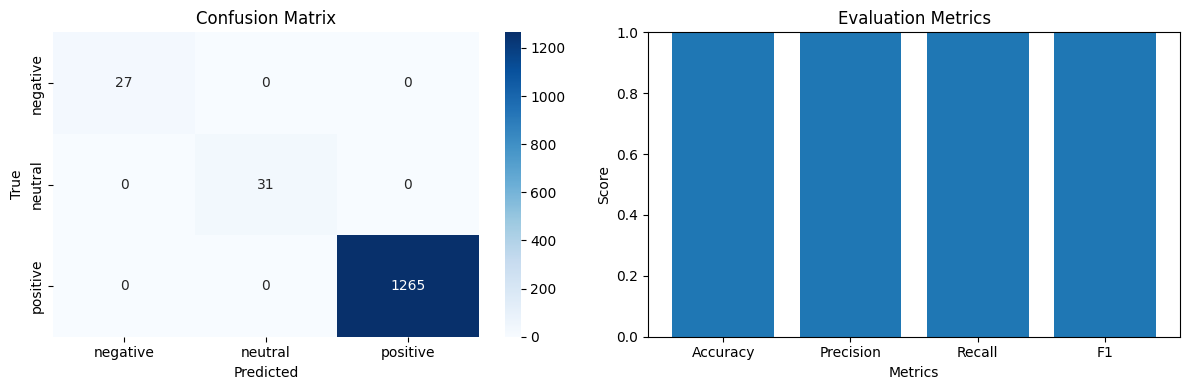

['SVM Linear', 1.0, 1.0, 1.0, 1.0]

In [ ]:
#SVM linear
clf = svm.SVC(kernel='linear')
svm_linear = build_model(clf, 'SVM Linear', x_train_new, y_train_new, x_test, y_test)
svm_linear

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       1.00      0.97      0.98        31
    positive       1.00      1.00      1.00      1265

    accuracy                           1.00      1323
   macro avg       1.00      0.99      0.99      1323
weighted avg       1.00      1.00      1.00      1323



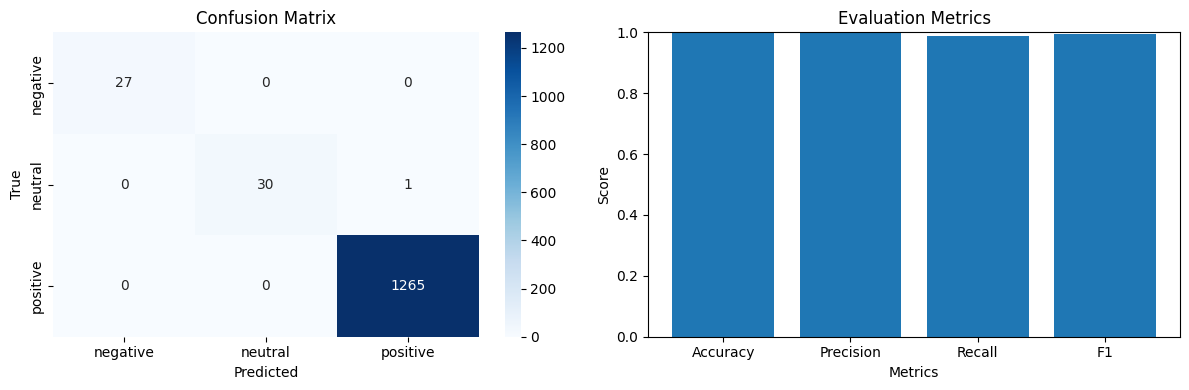

['SVM RBF', 1.0, 1.0, 0.99, 0.99]

In [ ]:
#SVM rbf
clf = svm.SVC()
svm_rbf = build_model(clf, 'SVM RBF', x_train_new, y_train_new, x_test, y_test)
svm_rbf

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



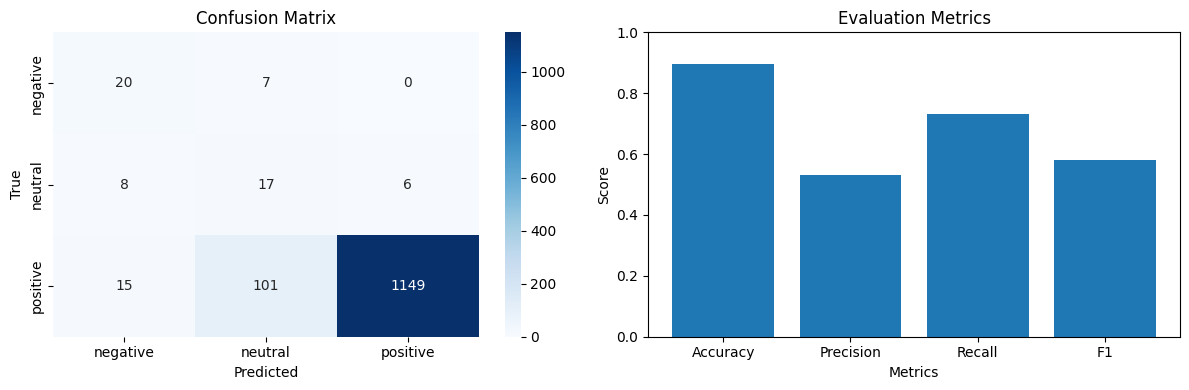

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



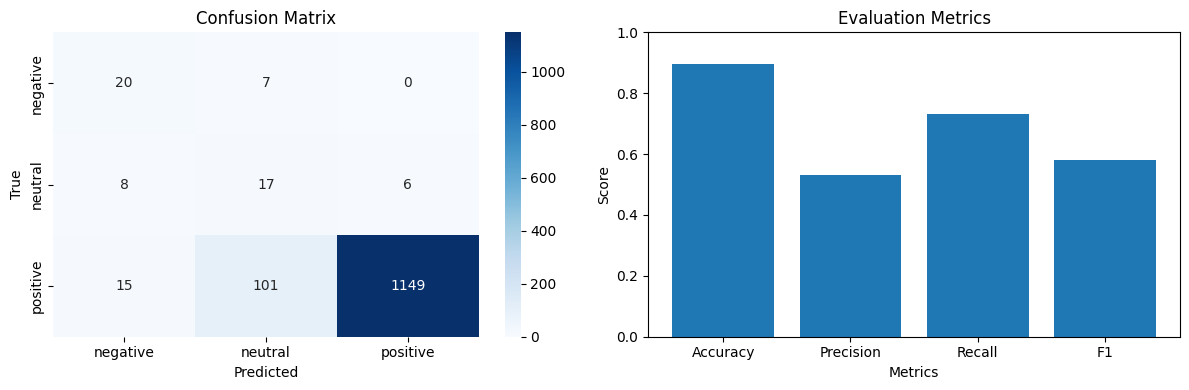

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



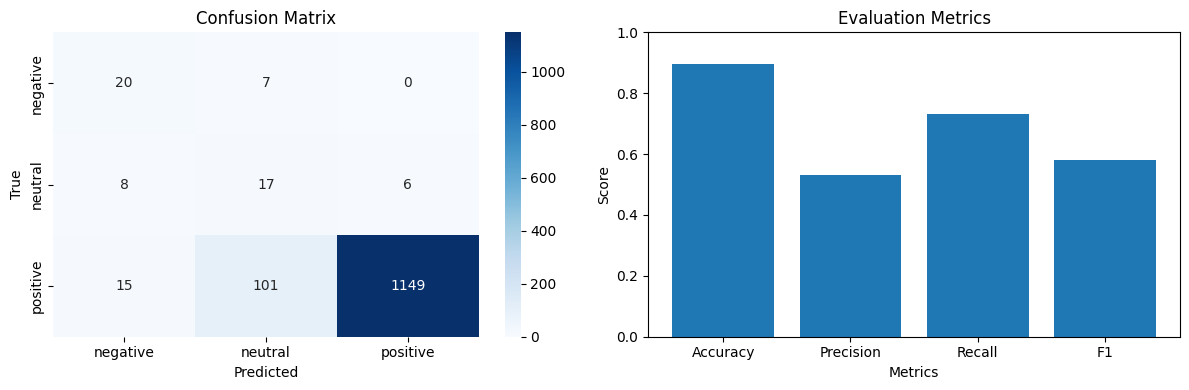

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



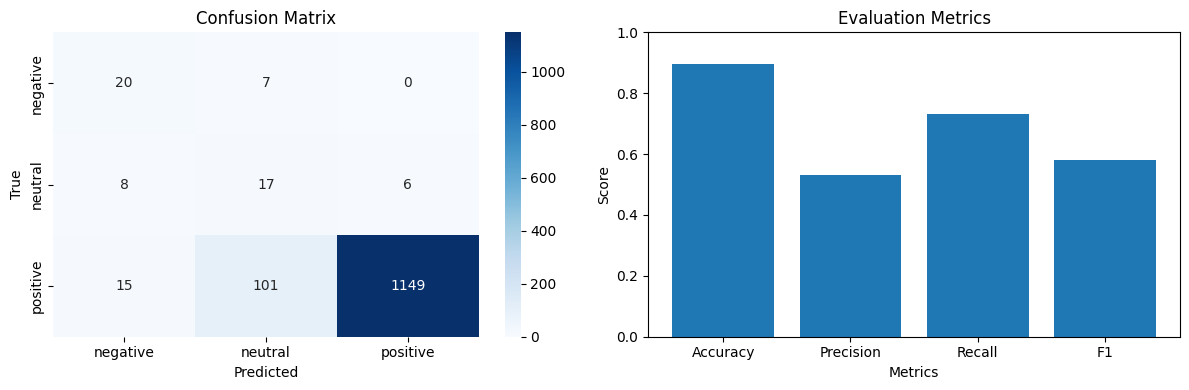

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



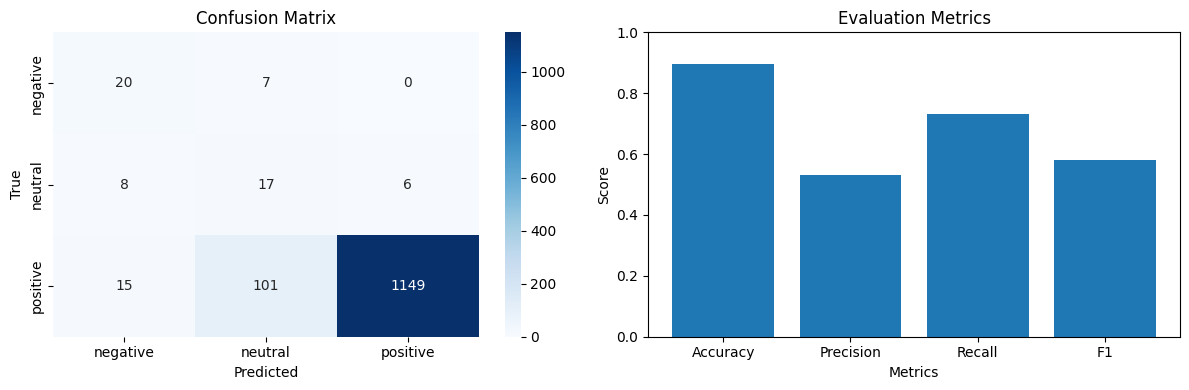

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



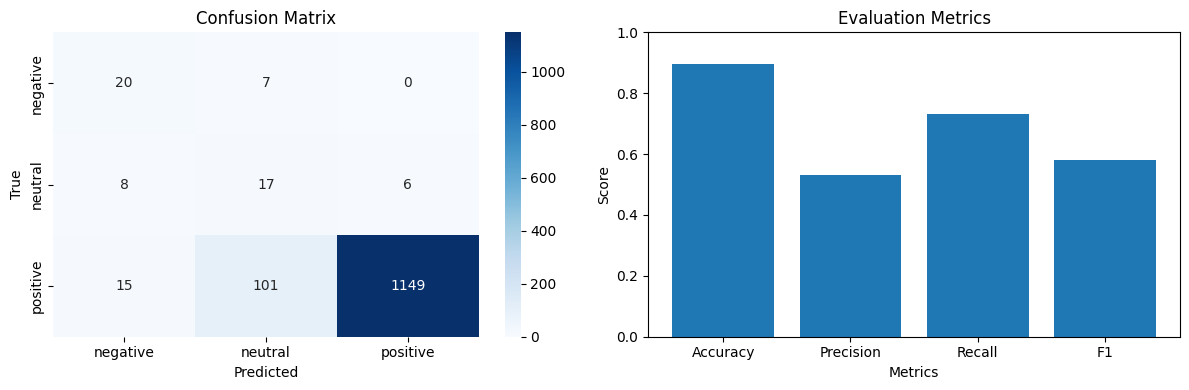

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



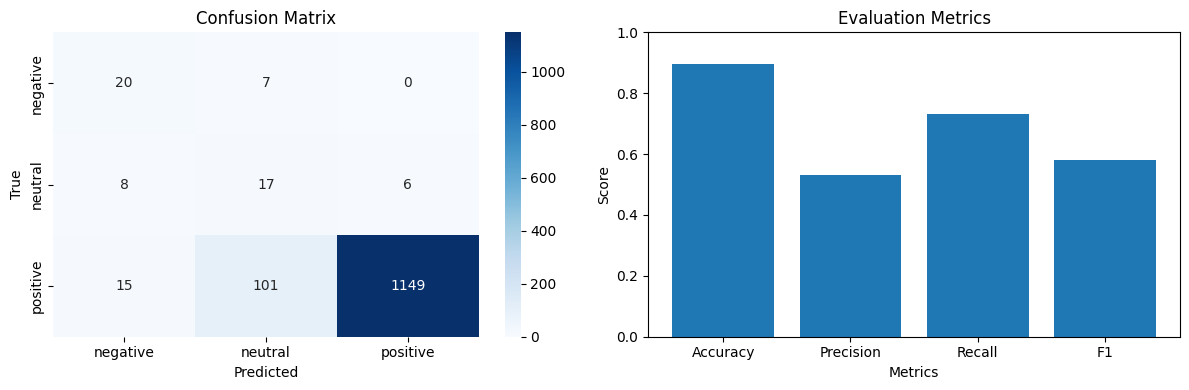

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



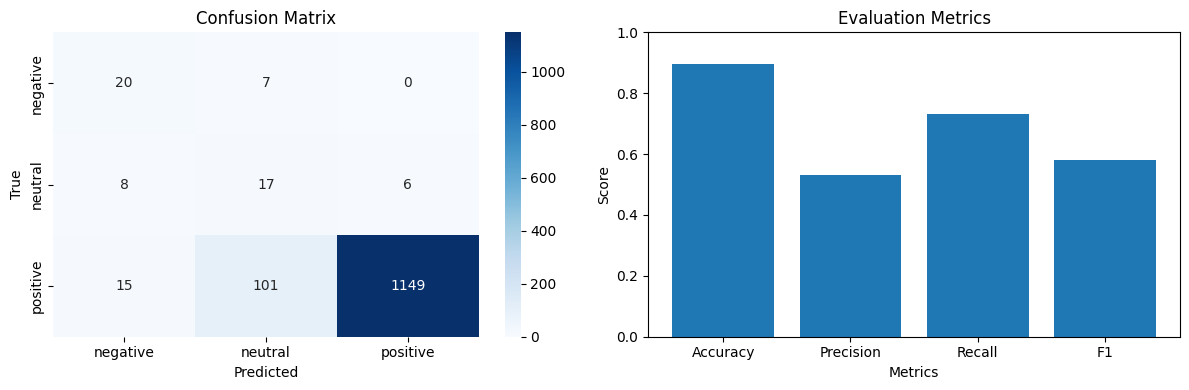

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



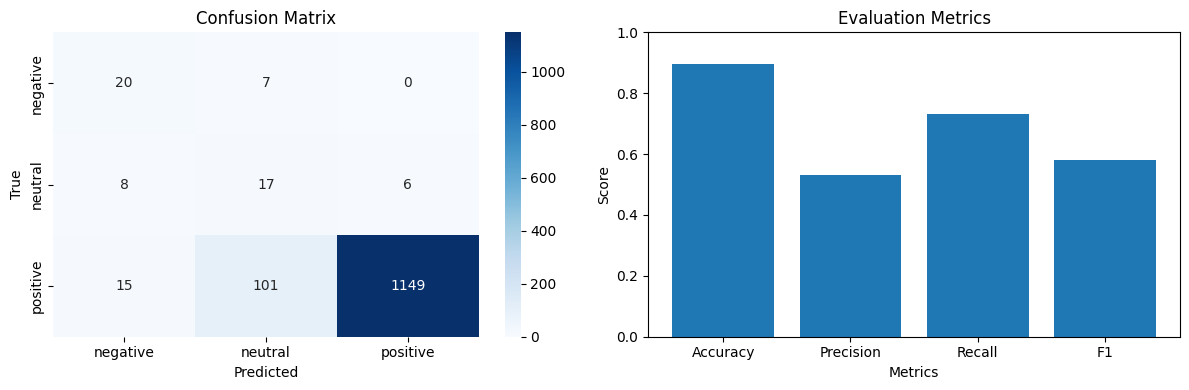

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



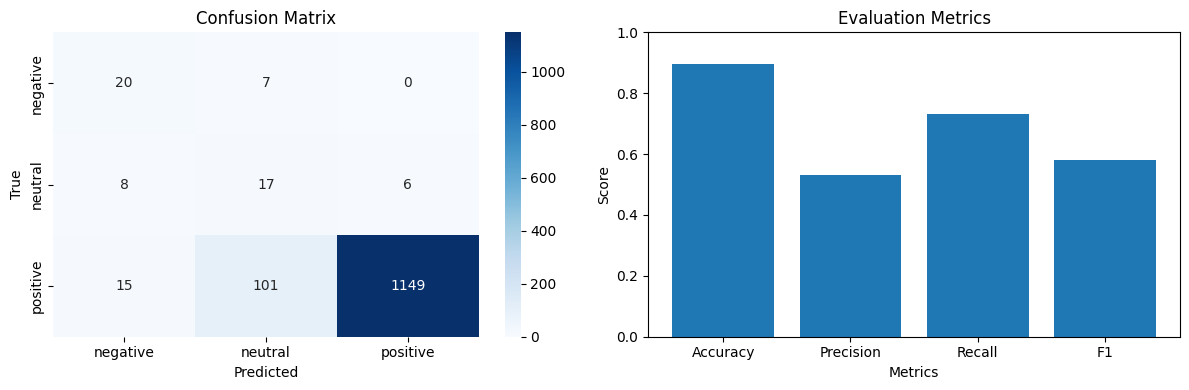

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



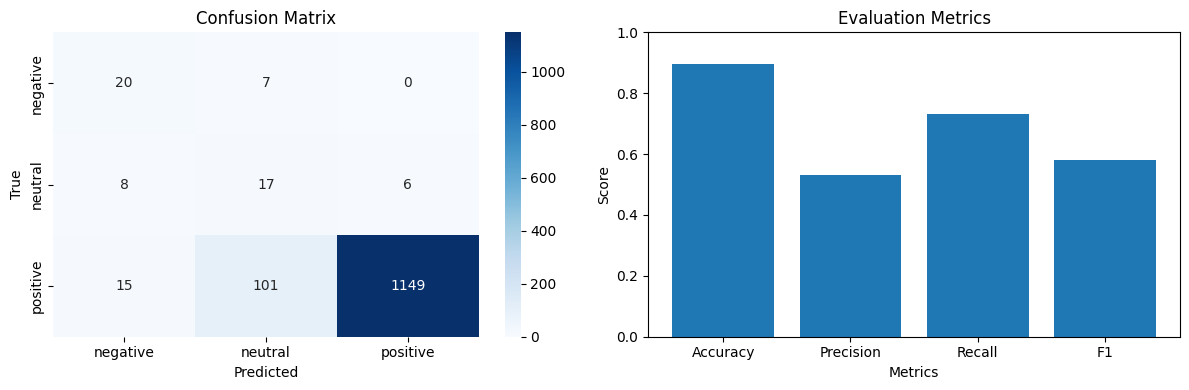

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



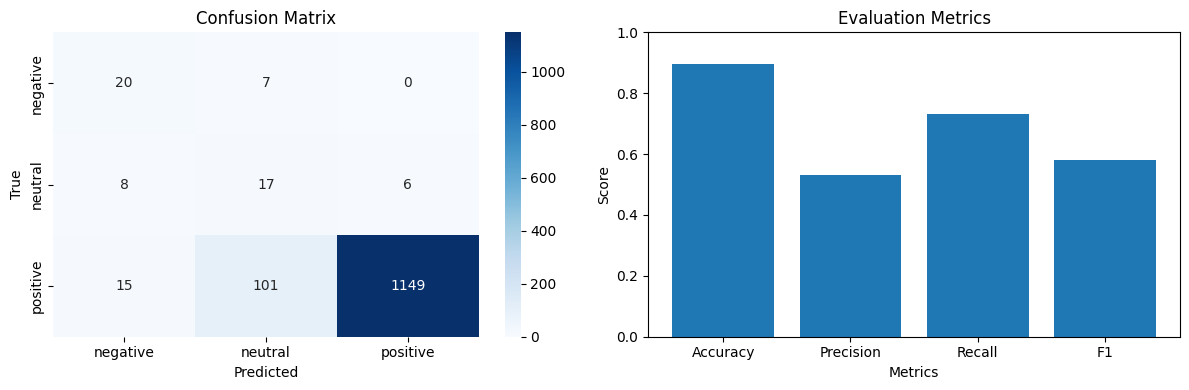

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



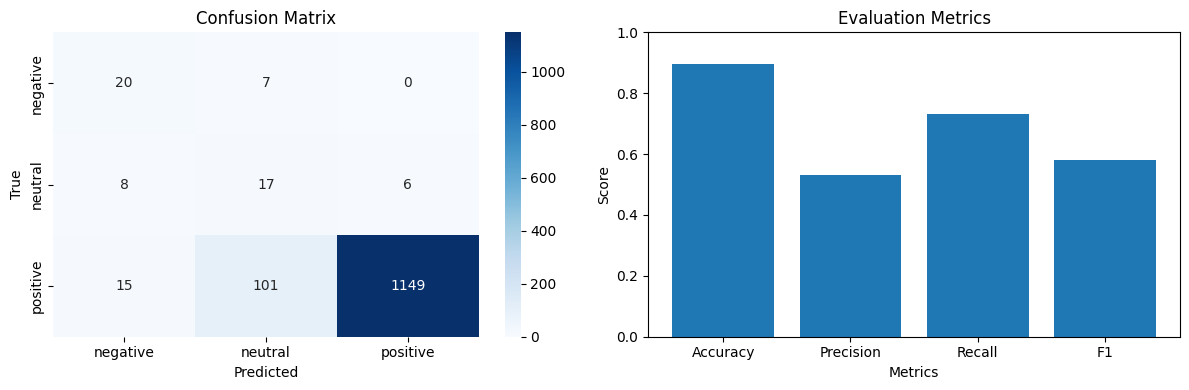

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



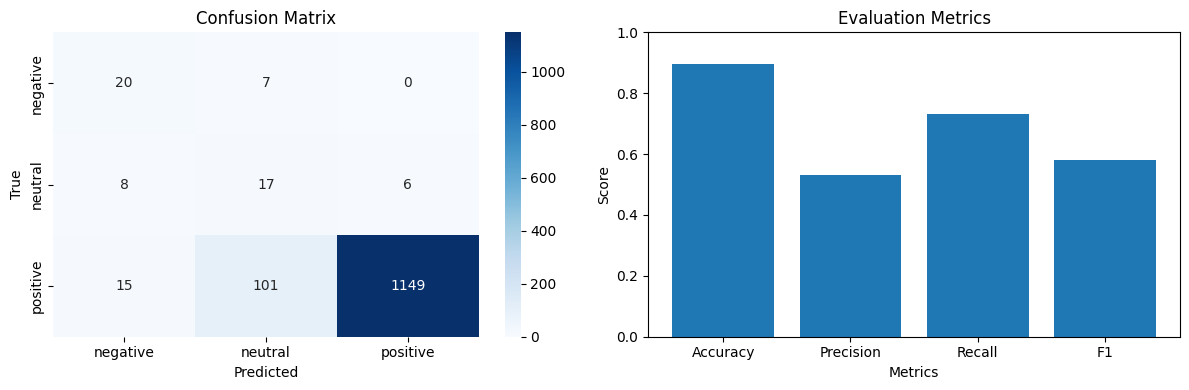

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



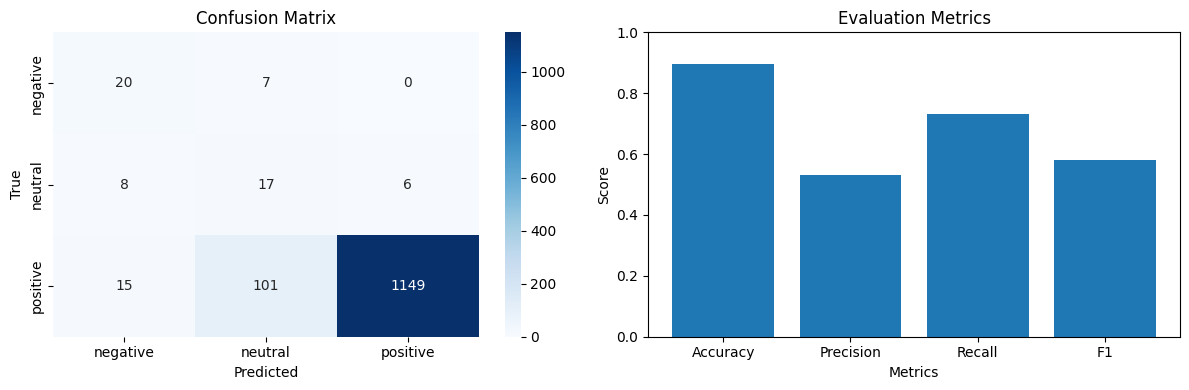

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



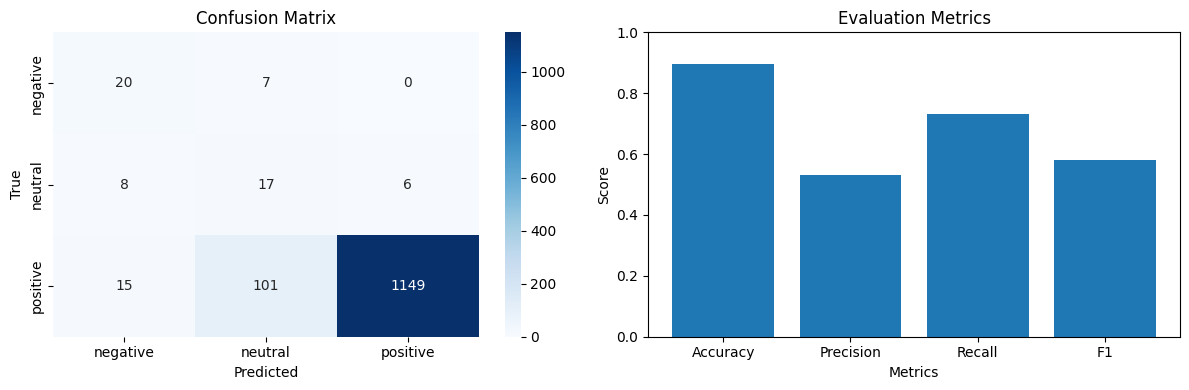

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



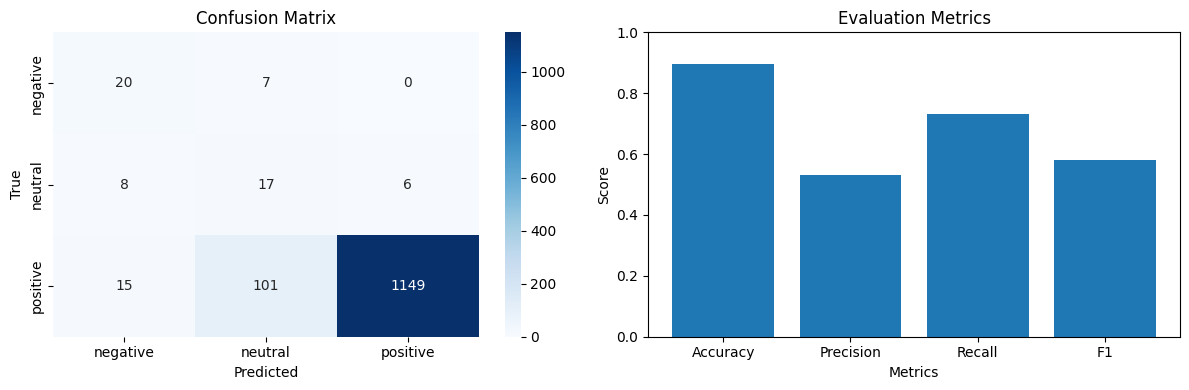

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



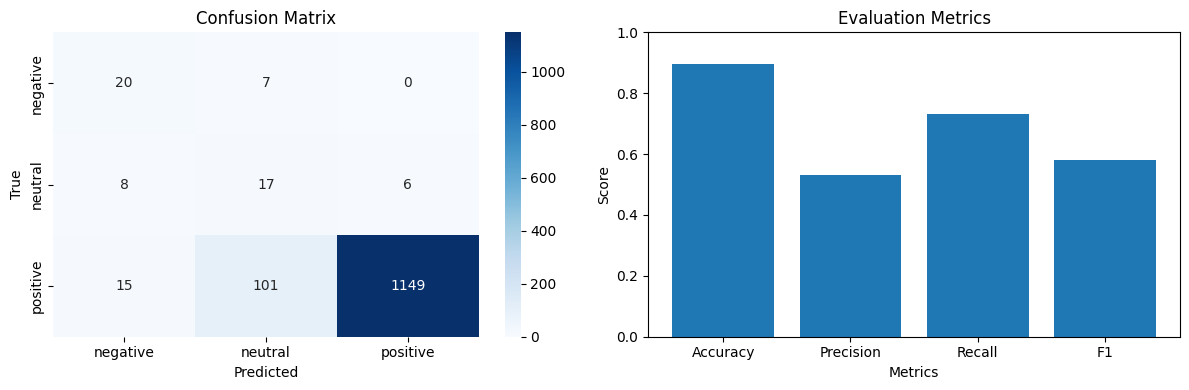

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



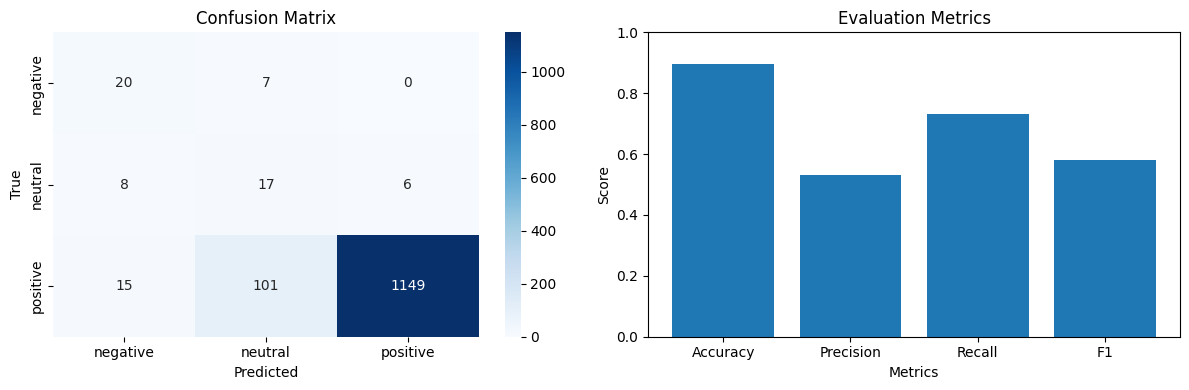

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



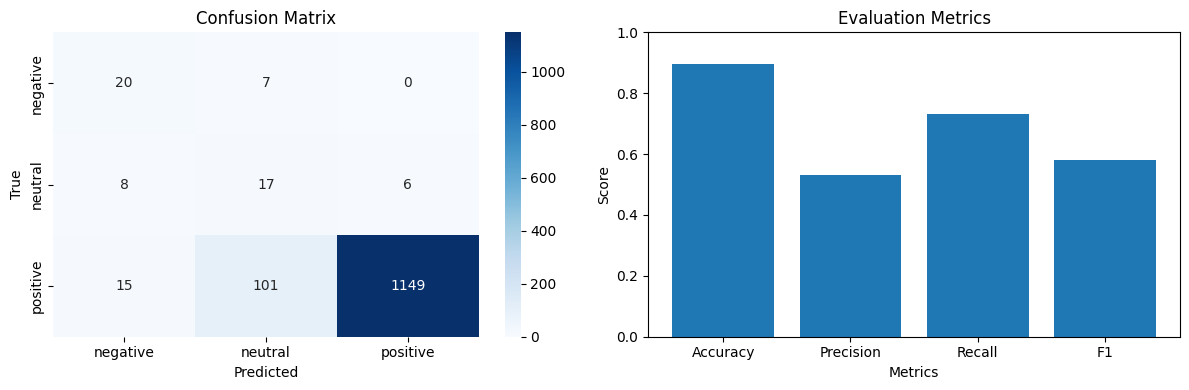

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



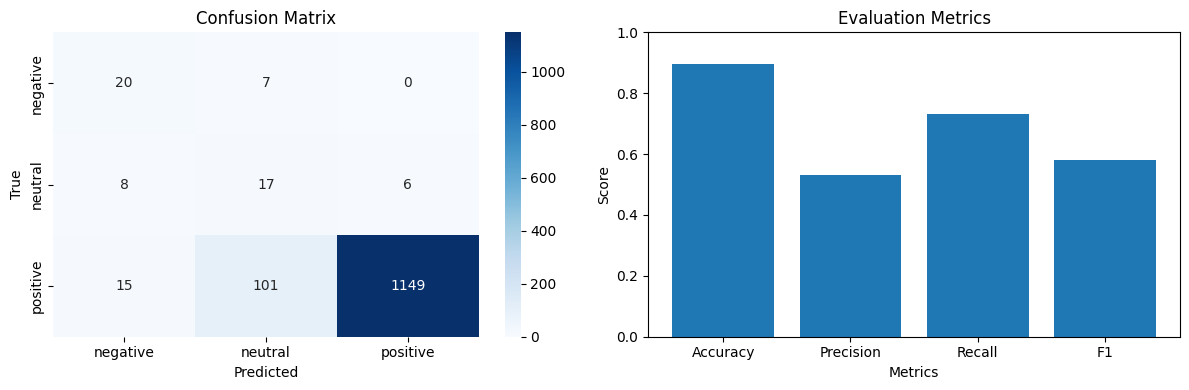

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



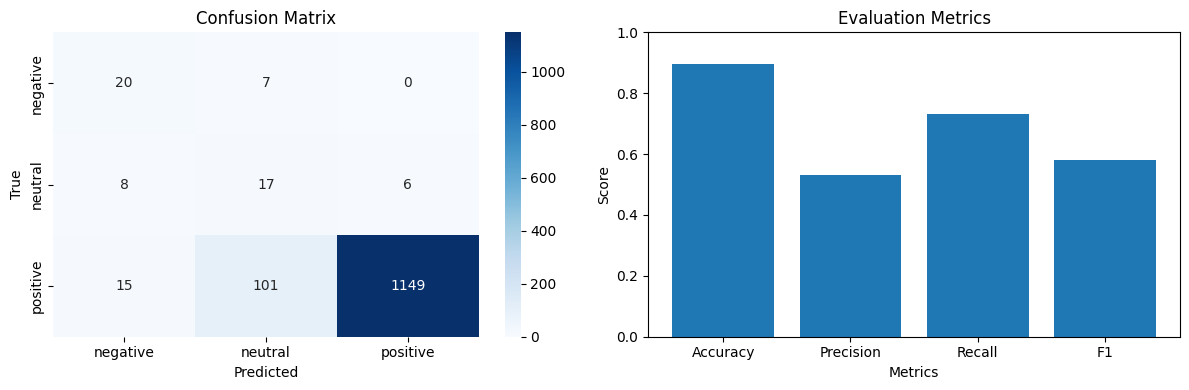

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



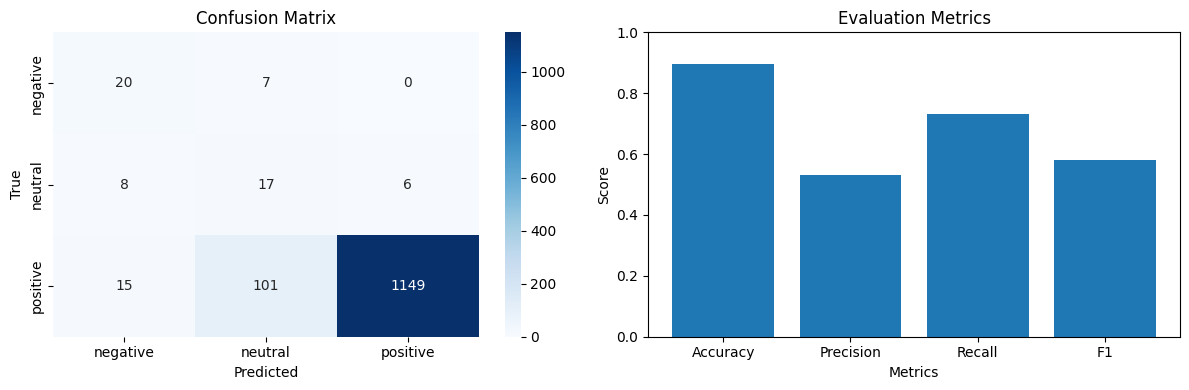

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



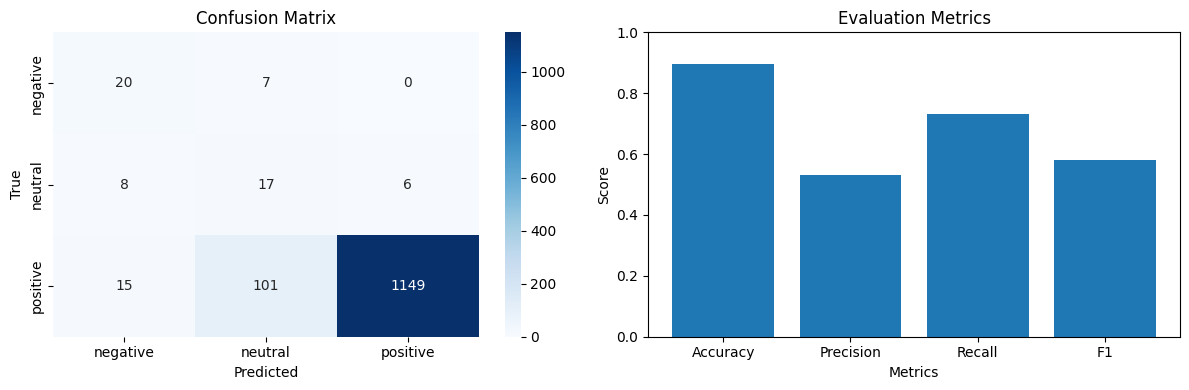

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



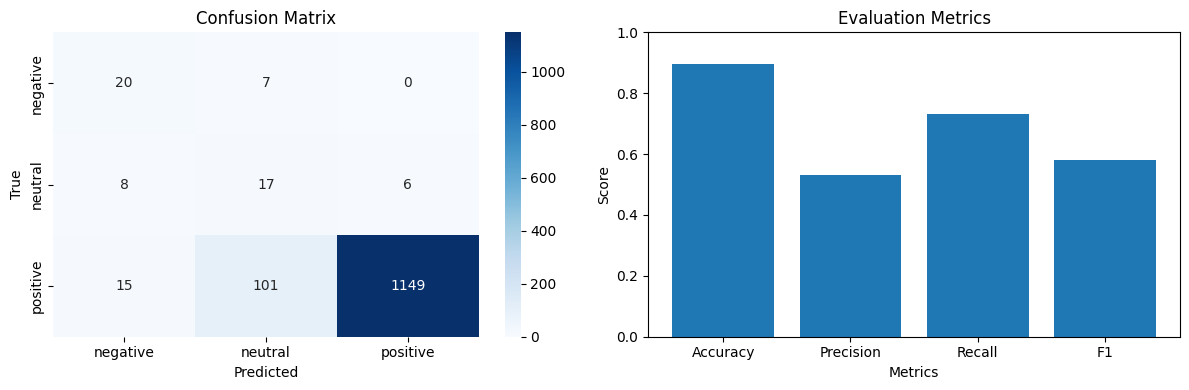

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



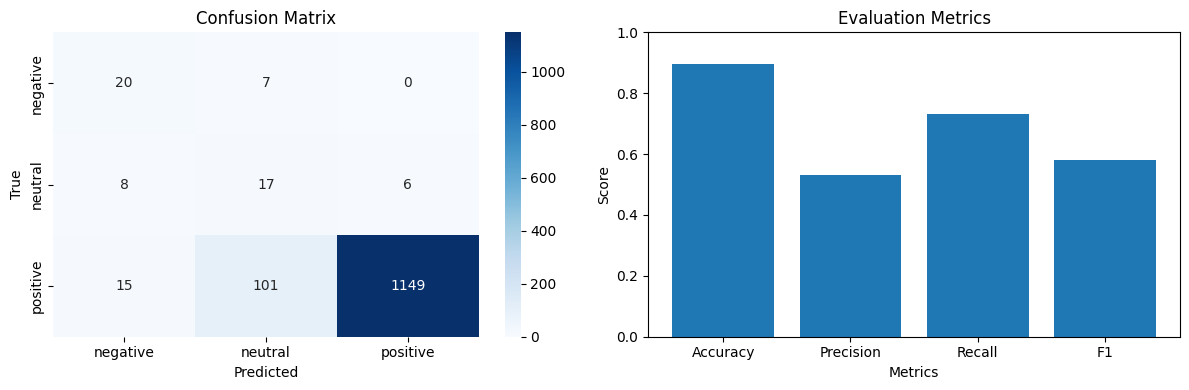

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



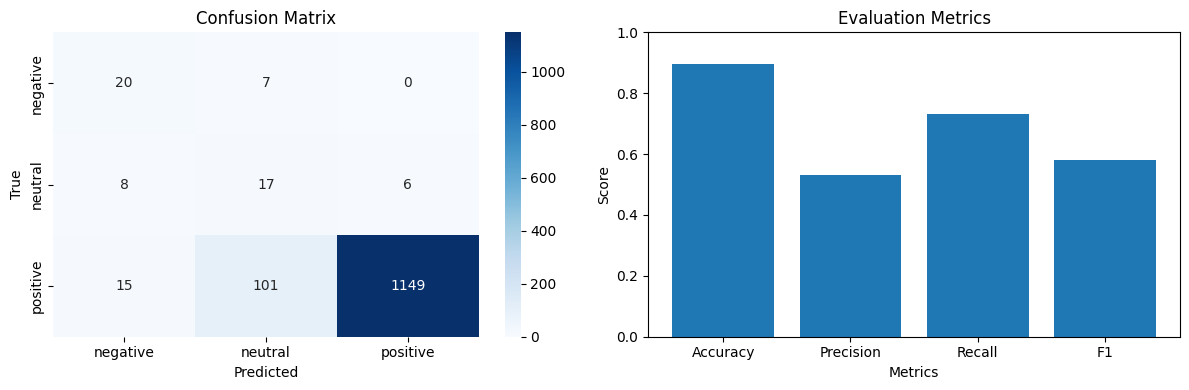

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



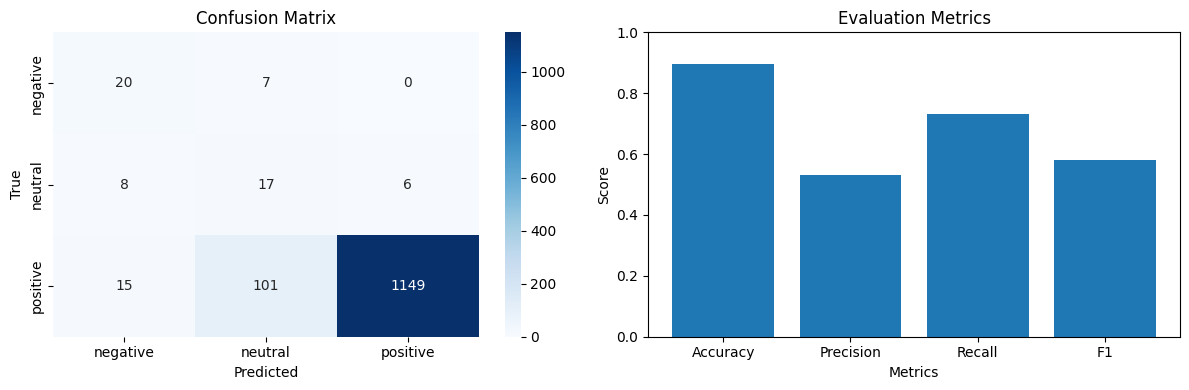

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



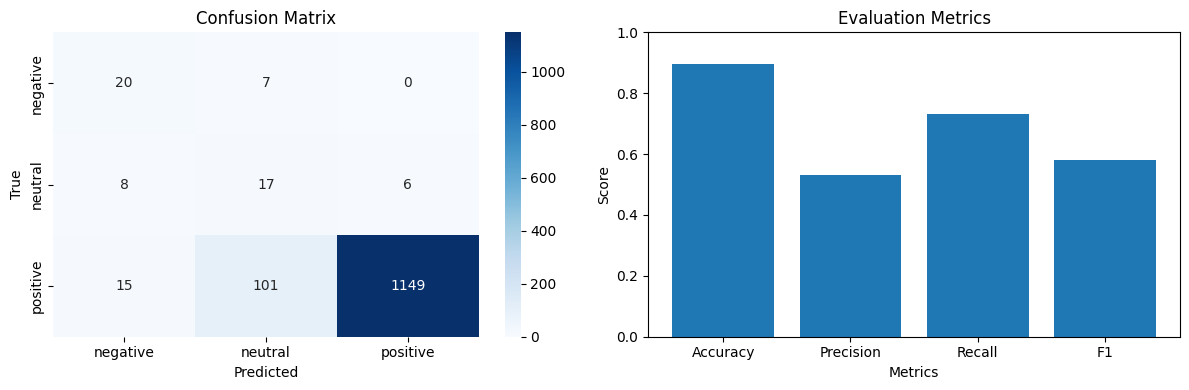

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



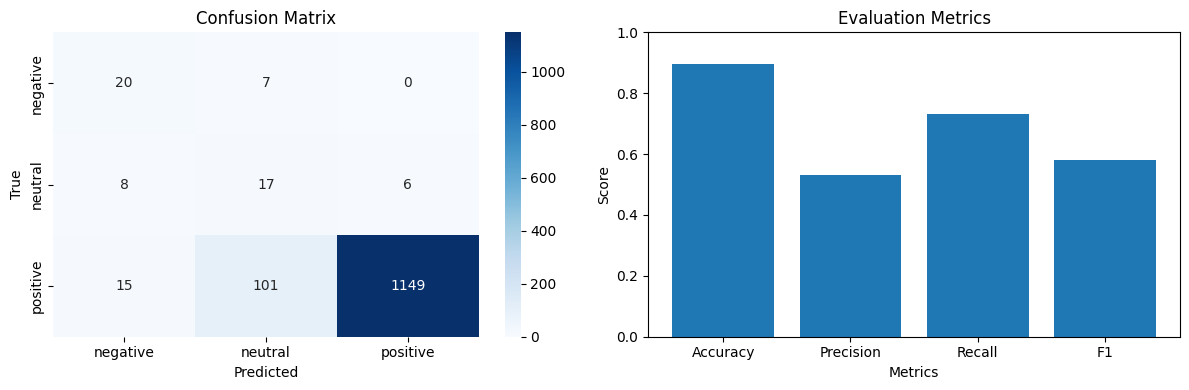

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



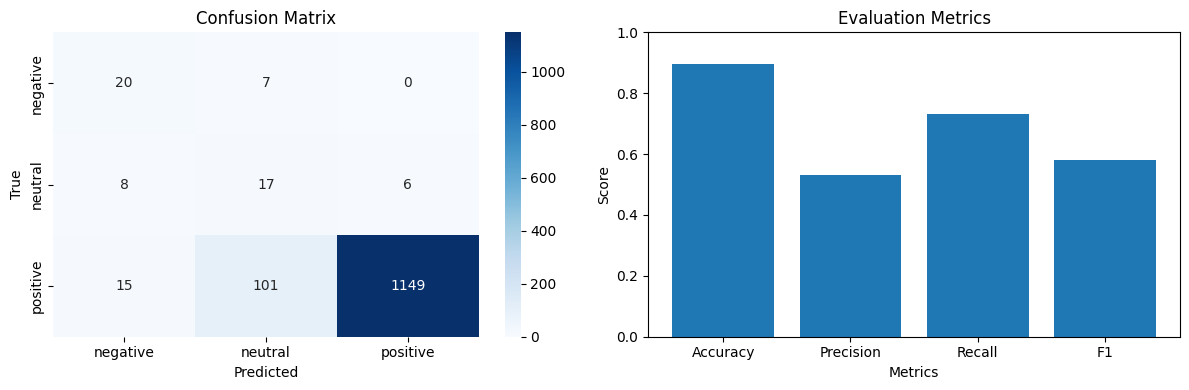

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



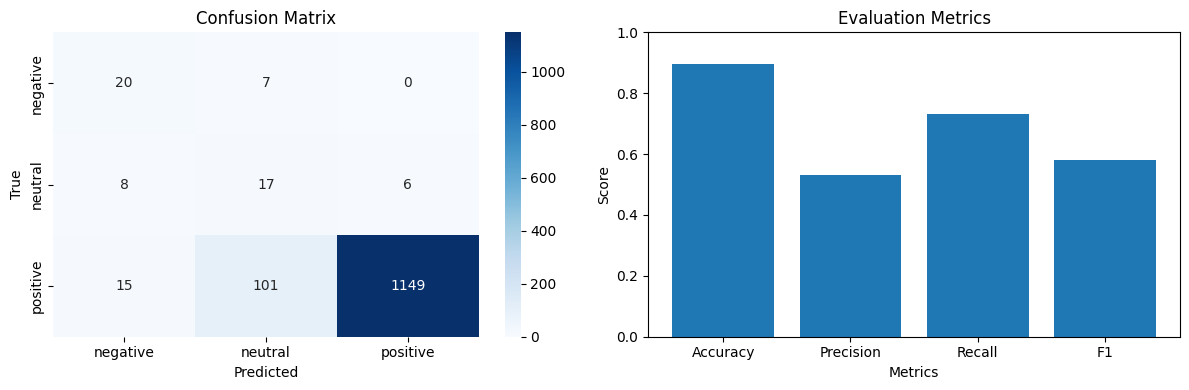

In [ ]:
#SVM sigmoid
d_range = range(2, 10)
acc=[]
pre=[]
re=[]
f1=[]
for d in d_range:
  clf = svm.SVC(kernel='sigmoid',degree=d)
  acc.append(build_model(clf, 'SVM Sigmoid', x_train_new, y_train_new, x_test, y_test)[1])
  pre.append(build_model(clf, 'SVM Sigmoid', x_train_new, y_train_new, x_test, y_test)[2])
  re.append(build_model(clf, 'SVM Sigmoid', x_train_new, y_train_new, x_test, y_test)[3])
  f1.append(build_model(clf, 'SVM Sigmoid', x_train_new, y_train_new, x_test, y_test)[4])

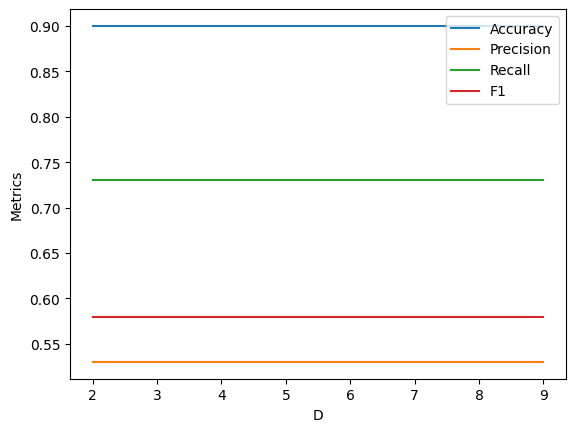

In [ ]:
plt.plot(d_range, acc, label='Accuracy')
plt.plot(d_range, pre, label='Precision')
plt.plot(d_range, re, label='Recall')
plt.plot(d_range, f1, label='F1')
plt.xlabel('D')
plt.ylabel('Metrics')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.47      0.74      0.57        27
     neutral       0.14      0.55      0.22        31
    positive       0.99      0.91      0.95      1265

    accuracy                           0.90      1323
   macro avg       0.53      0.73      0.58      1323
weighted avg       0.96      0.90      0.92      1323



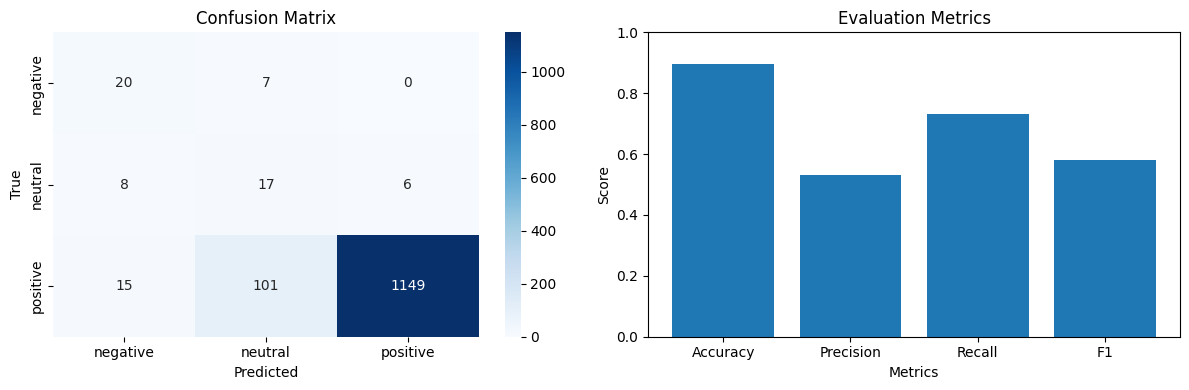

['SVM Sigmoid', 0.9, 0.53, 0.73, 0.58]

In [ ]:
#SVM sigmoid
clf = svm.SVC(kernel='sigmoid')
svm_sigmoid= build_model(clf, 'SVM Sigmoid', x_train_new, y_train_new, x_test, y_test)
svm_sigmoid

<ipython-input-9-fe0465b39e79>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive 

              precision    recall  f1-score   support

    negative       0.69      1.00      0.82        27
     neutral       0.16      0.81      0.27        31
    positive       1.00      0.89      0.94      1265

    accuracy                           0.89      1323
   macro avg       0.62      0.90      0.68      1323
weighted avg       0.97      0.89      0.92      1323



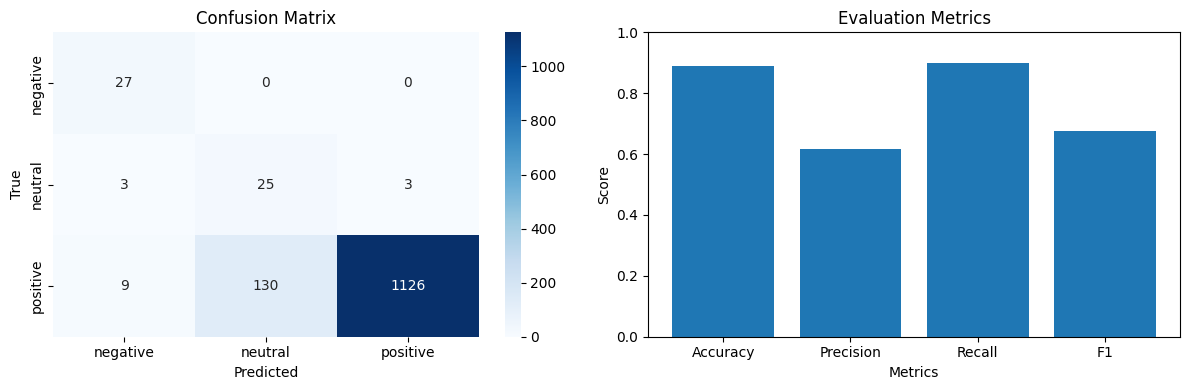

['Random Forest', 0.89, 0.62, 0.9, 0.68]

In [ ]:
#Random forest
clf = RandomForestClassifier(n_estimators=100, max_depth=6, max_leaf_nodes=9)
rf= build_model(clf, 'Random Forest', x_train_new, y_train_new, x_test, y_test)
rf

In [ ]:
from sklearn.model_selection import  GridSearchCV as gs_cv
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
}
grid_class = gs_cv(estimator=RandomForestClassifier(), param_grid=param_grid, n_jobs=2,scoring='accuracy',refit = True, return_train_score=True,cv=10)
grid_class.fit(x_train_new, y_train_new)
print('Best_param:',grid_class.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96        27
     neutral       0.84      0.87      0.86        31
    positive       1.00      1.00      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



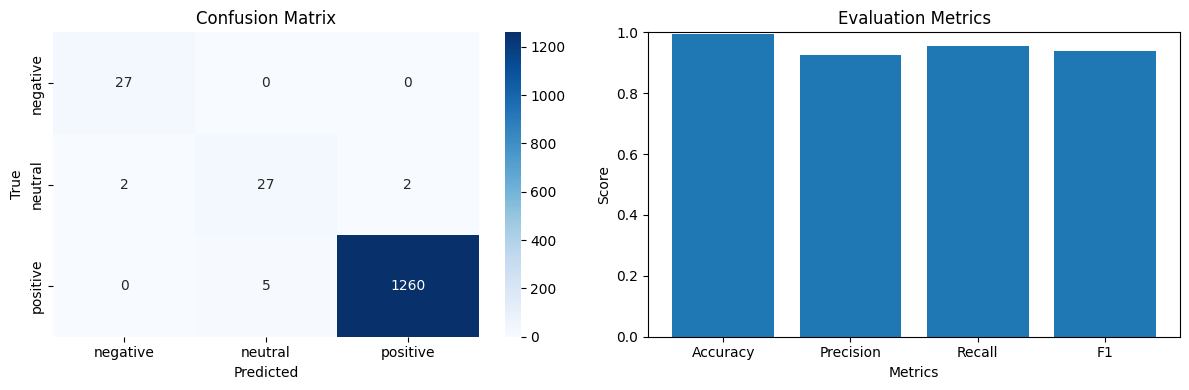

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96        27
     neutral       0.84      0.87      0.86        31
    positive       1.00      1.00      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



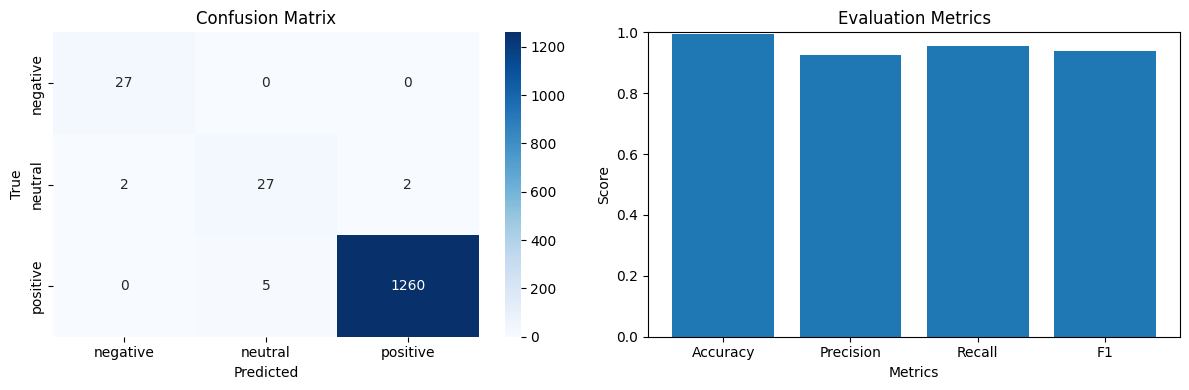

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96        27
     neutral       0.84      0.87      0.86        31
    positive       1.00      1.00      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



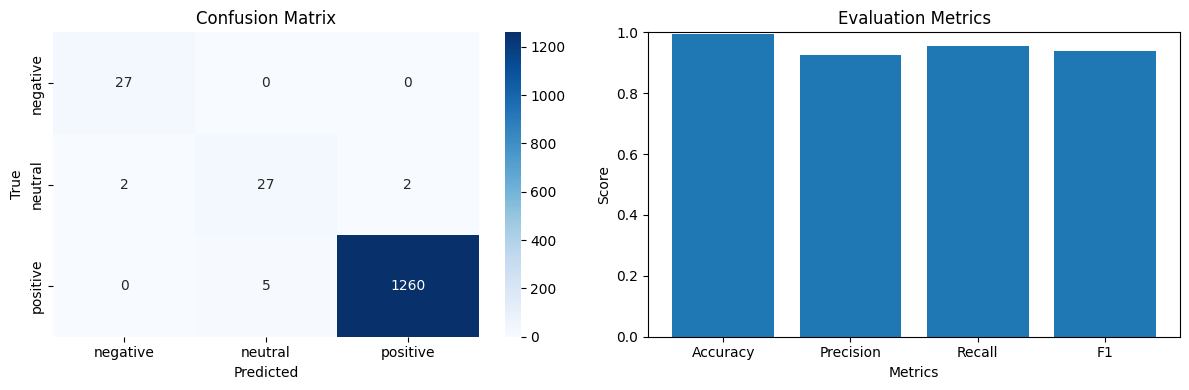

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.93      1.00      0.96        27
     neutral       0.84      0.87      0.86        31
    positive       1.00      1.00      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



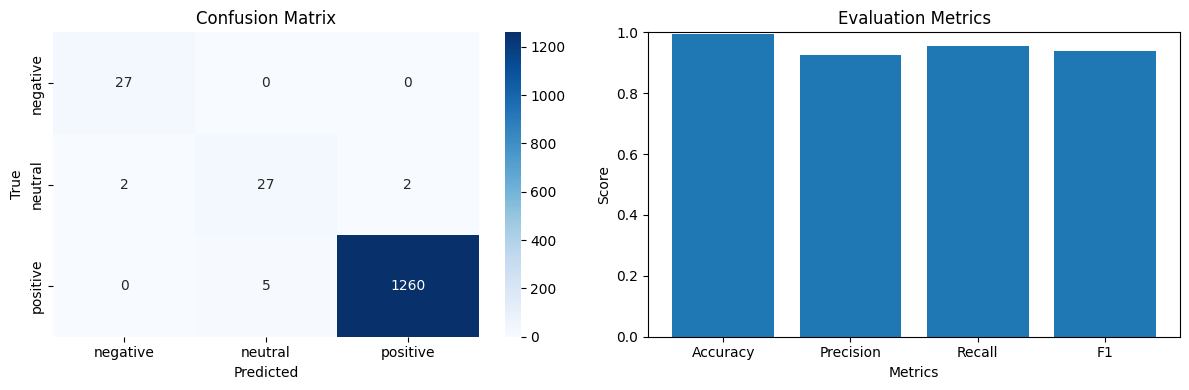

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.79      0.87      0.83        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



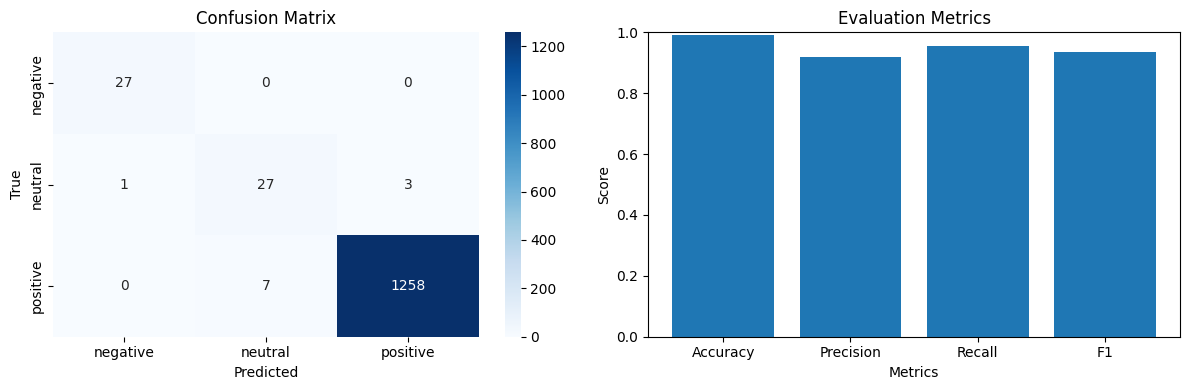

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.79      0.87      0.83        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



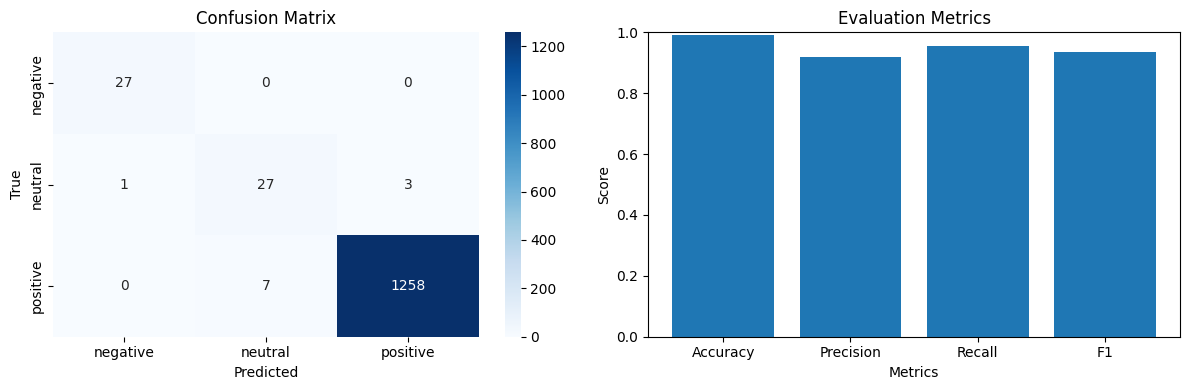

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.79      0.87      0.83        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



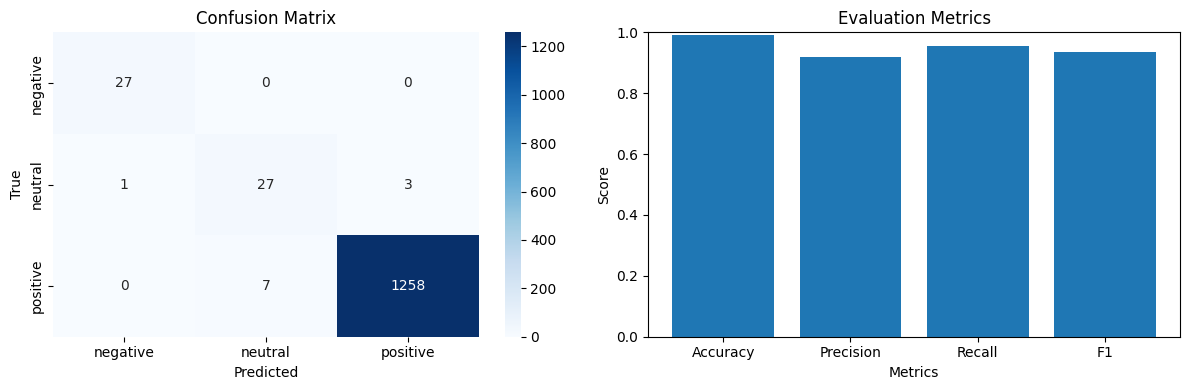

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.79      0.87      0.83        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.96      0.94      1323
weighted avg       0.99      0.99      0.99      1323



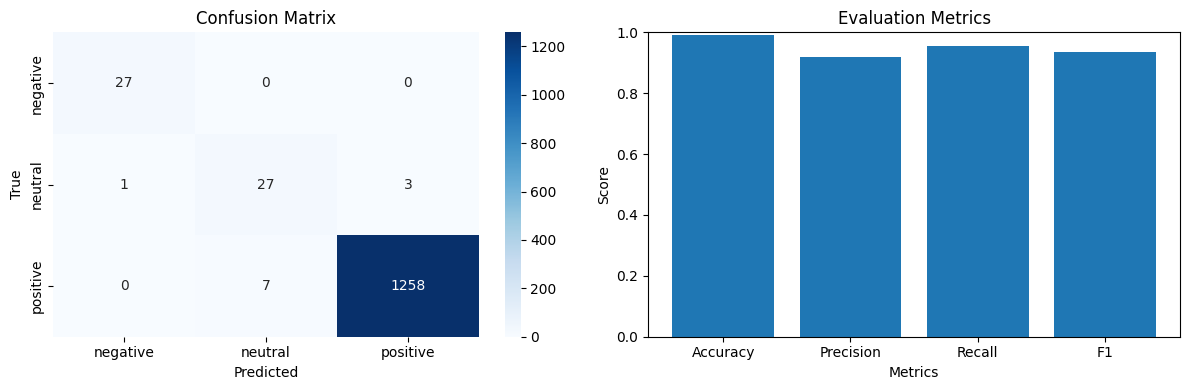

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



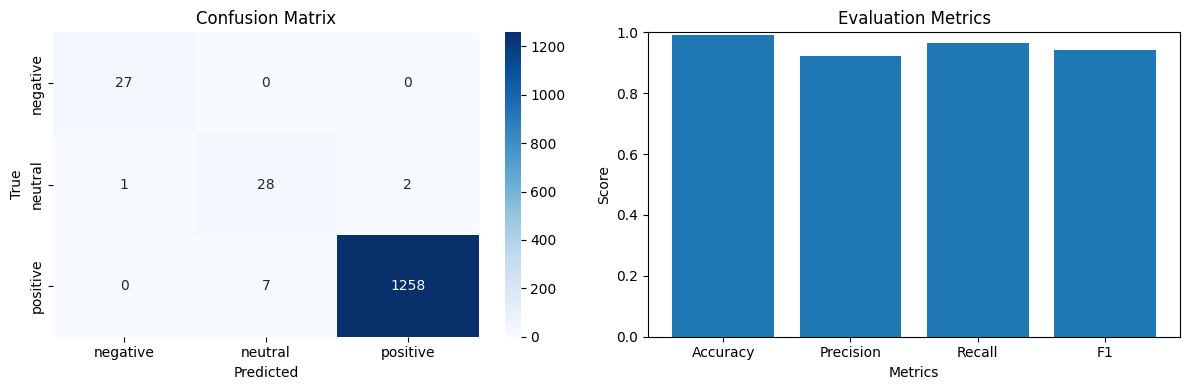

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



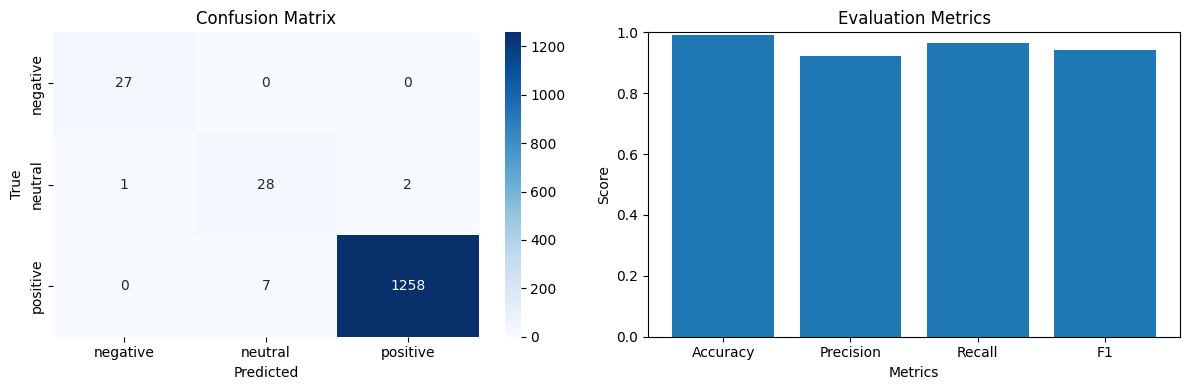

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



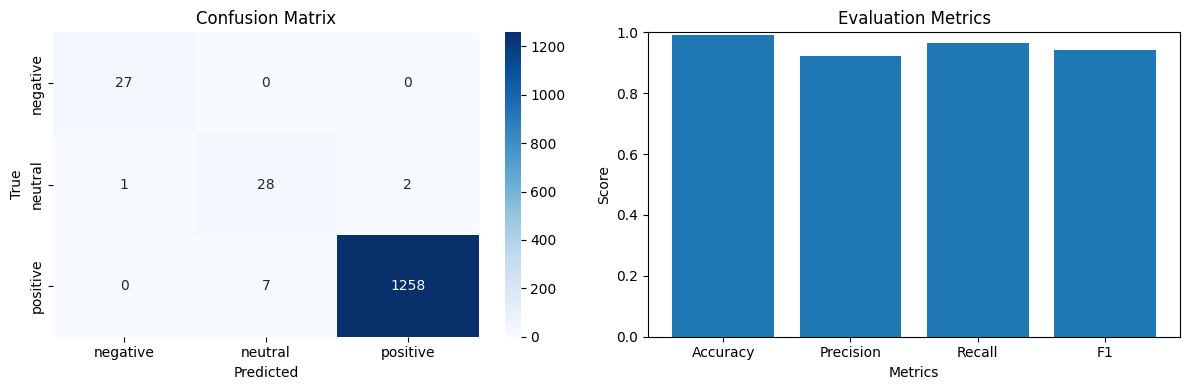

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



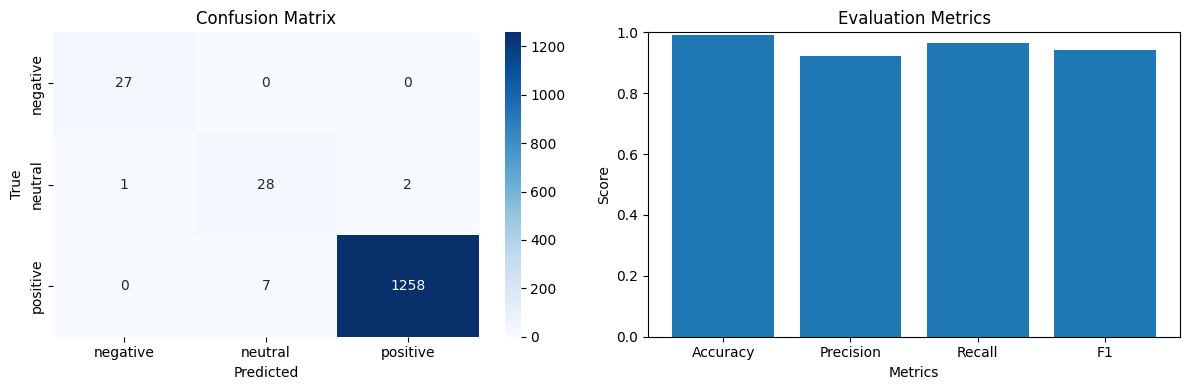

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



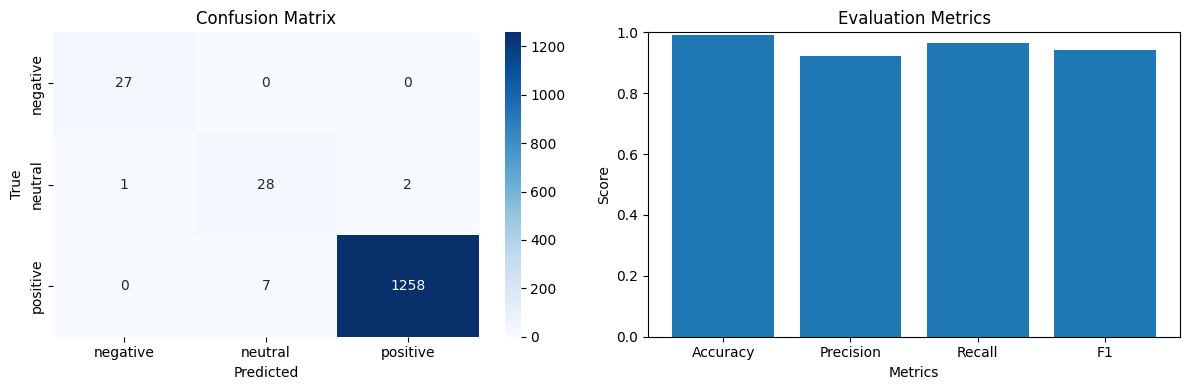

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



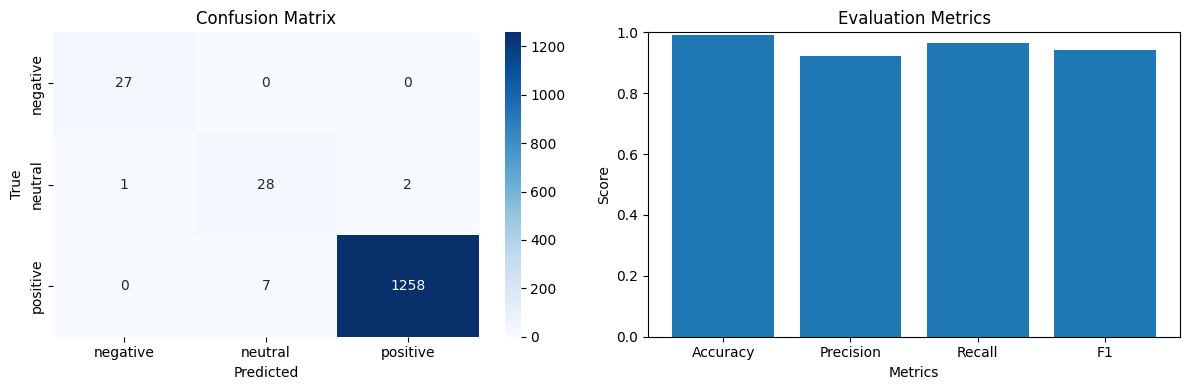

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



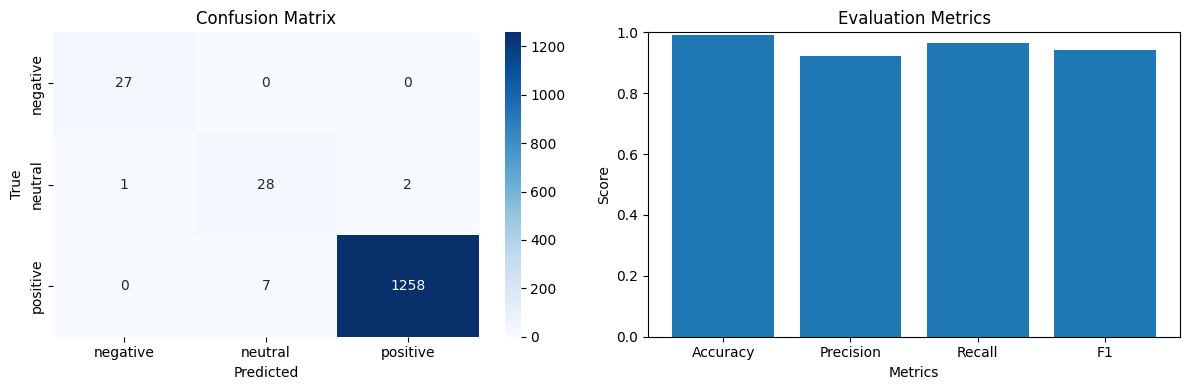

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       0.96      1.00      0.98        27
     neutral       0.80      0.90      0.85        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.92      0.97      0.94      1323
weighted avg       0.99      0.99      0.99      1323



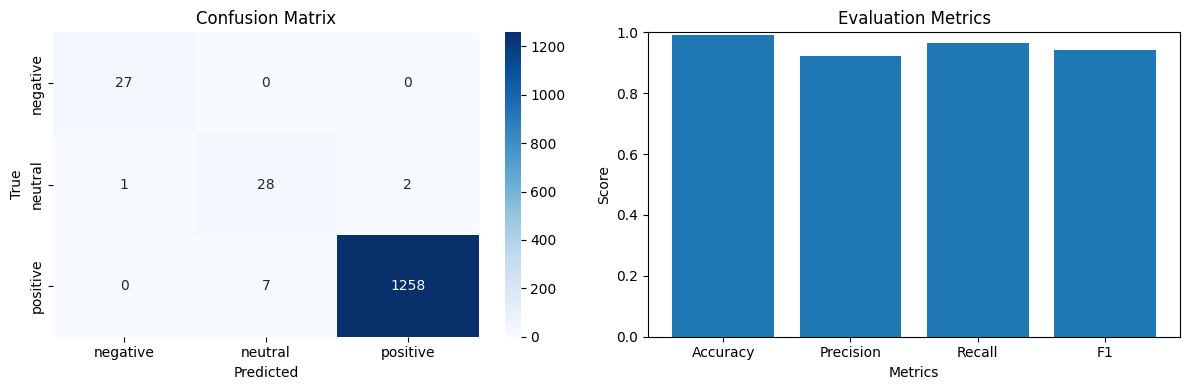

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       0.81      0.97      0.88        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.94      0.99      0.96      1323
weighted avg       0.99      0.99      0.99      1323



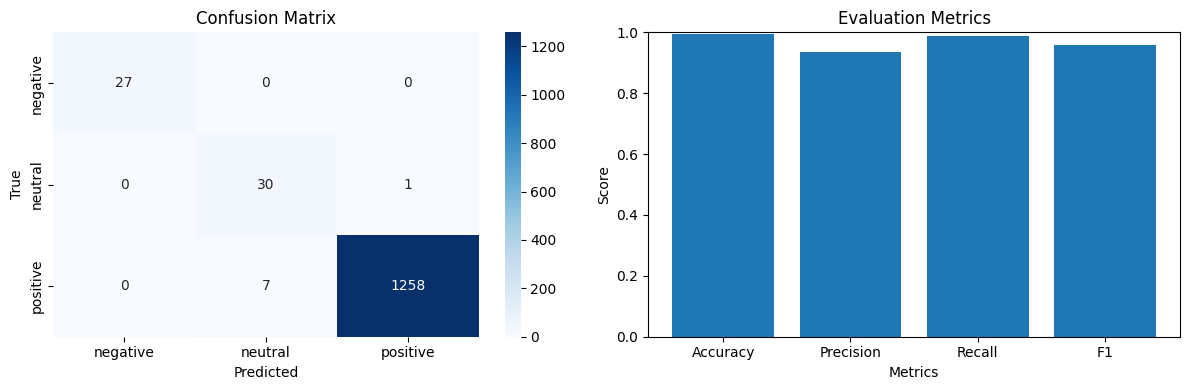

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       0.81      0.97      0.88        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.94      0.99      0.96      1323
weighted avg       0.99      0.99      0.99      1323



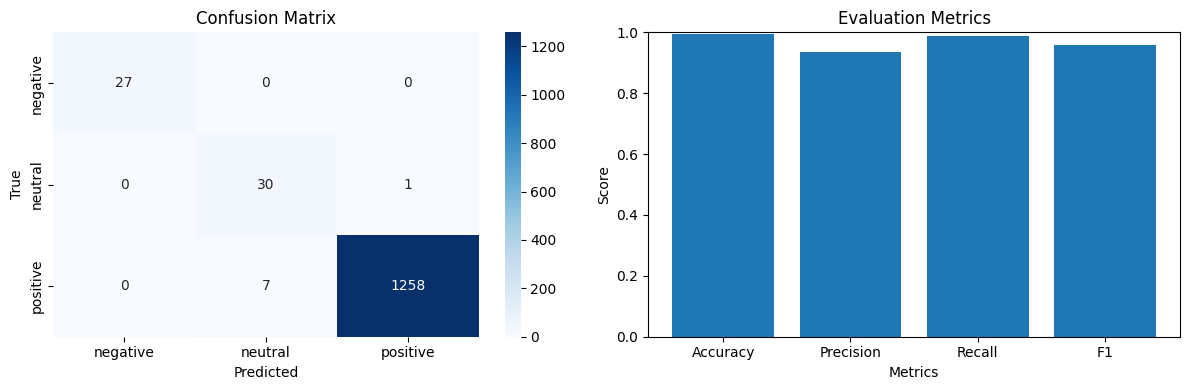

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       0.81      0.97      0.88        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.94      0.99      0.96      1323
weighted avg       0.99      0.99      0.99      1323



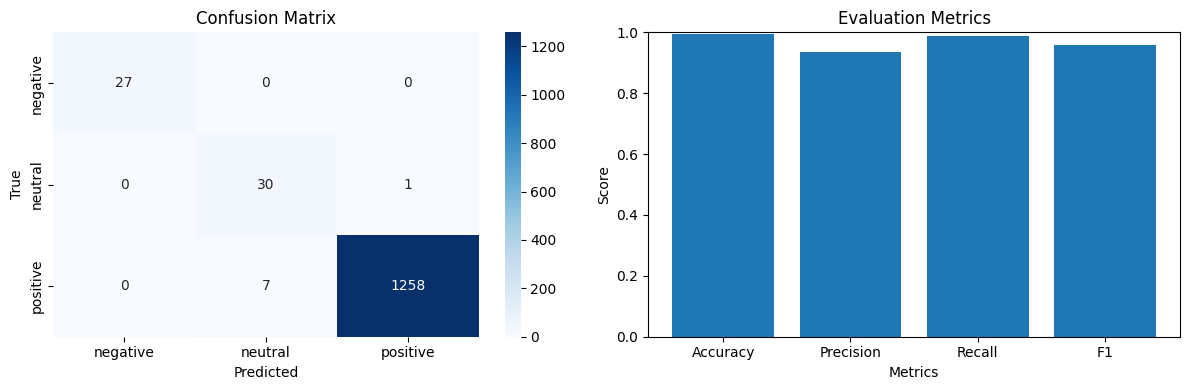

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       0.81      0.97      0.88        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.94      0.99      0.96      1323
weighted avg       0.99      0.99      0.99      1323



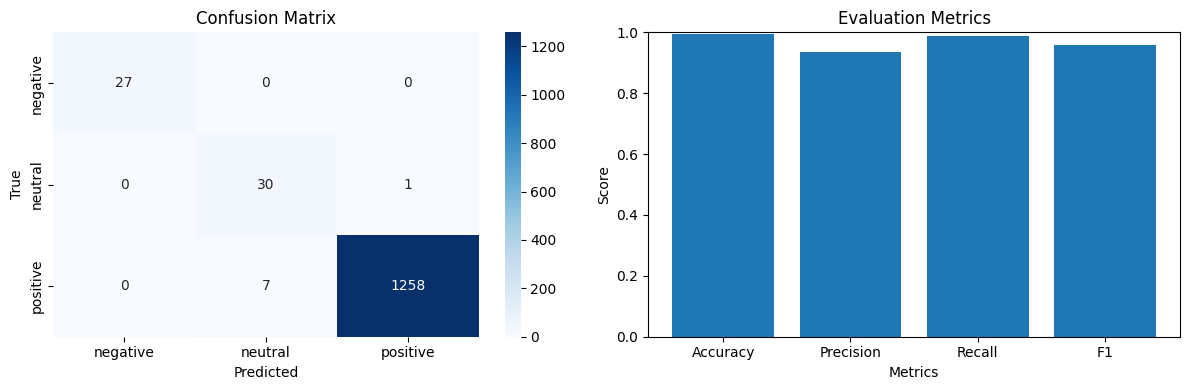

In [ ]:
k_range = range(1, 10, 2)
acc=[]
pre=[]
re=[]
f1=[]
for k in k_range:
  clf = KNeighborsClassifier(n_neighbors=k)
  acc.append(build_model(clf, 'KNN', x_train_new, y_train_new, x_test, y_test)[1])
  pre.append(build_model(clf, 'KNN', x_train_new, y_train_new, x_test, y_test)[2])
  re.append(build_model(clf, 'KNN', x_train_new, y_train_new, x_test, y_test)[3])
  f1.append(build_model(clf, 'KNN', x_train_new, y_train_new, x_test, y_test)[4])

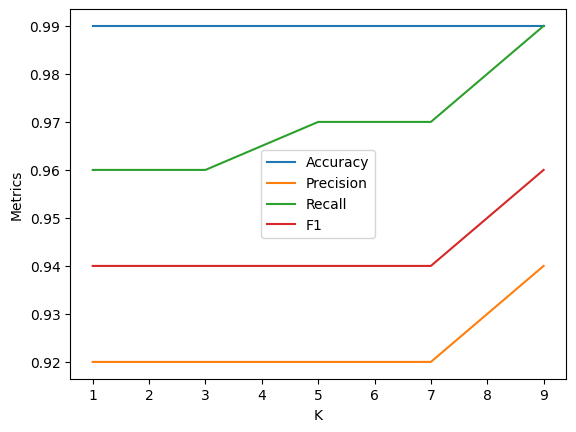

In [ ]:
plt.plot(k_range, acc, label='Accuracy')
plt.plot(k_range, pre, label='Precision')
plt.plot(k_range, re, label='Recall')
plt.plot(k_range, f1, label='F1')
plt.xlabel('K')
plt.ylabel('Metrics')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use lab

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        27
     neutral       0.81      0.97      0.88        31
    positive       1.00      0.99      1.00      1265

    accuracy                           0.99      1323
   macro avg       0.94      0.99      0.96      1323
weighted avg       0.99      0.99      0.99      1323



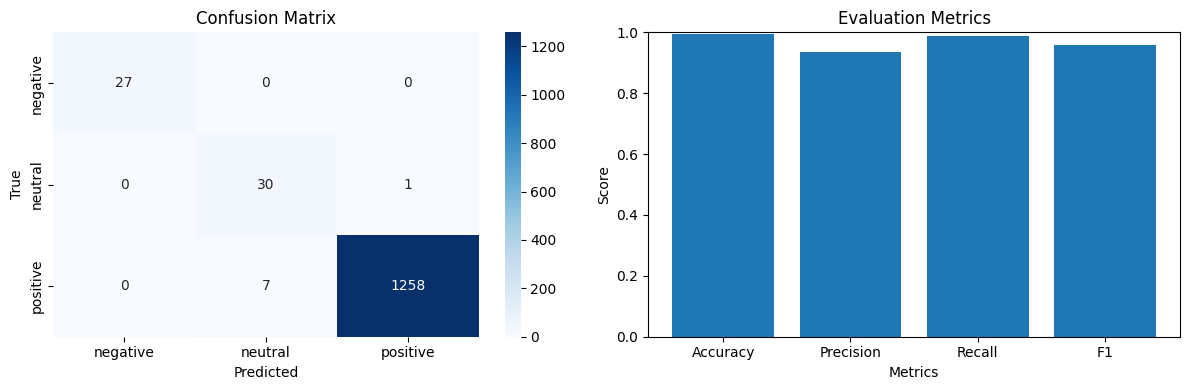

['KNN', 0.99, 0.94, 0.99, 0.96]

In [ ]:
knn = build_model(KNeighborsClassifier(n_neighbors=9),'KNN', x_train_new,y_train_new,x_test,y_test)
knn

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use la

              precision    recall  f1-score   support

    negative       0.21      0.85      0.34        27
     neutral       1.00      0.52      0.68        31
    positive       0.99      0.94      0.96      1265

    accuracy                           0.92      1323
   macro avg       0.73      0.77      0.66      1323
weighted avg       0.97      0.92      0.94      1323



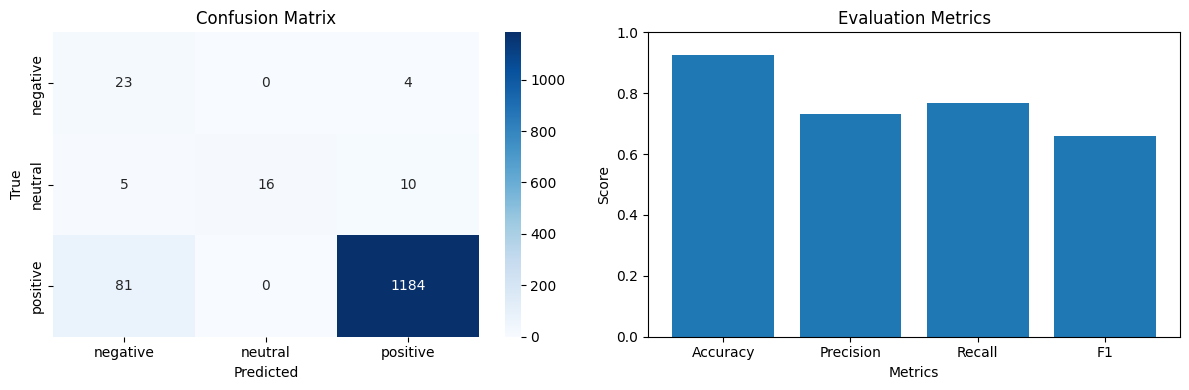

['Naïve Bayes', 0.92, 0.73, 0.77, 0.66]

In [ ]:
nb =build_model(GaussianNB(),'Naïve Bayes', x_train_new,y_train_new,x_test,y_test)
nb

In [ ]:
from sklearn.preprocessing import LabelEncoder
# Neural network 
label_encoder = LabelEncoder()
y_train_ecoder = label_encoder.fit_transform(y_train_new)
y_test_ecoder = label_encoder.transform(y_test)
y_train_class = keras.utils.to_categorical (y_train_ecoder, 3)
y_test_class = keras.utils.to_categorical (y_test_ecoder, 3)
model = Sequential()
model.add(Dense(500,input_dim=103, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(180, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(x_train_new, y_train_class, epochs=20, batch_size=128, verbose=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/20
119/119 [==============================] - 3s 9ms/step - loss: 0.0876 - accuracy: 0.9702
Epoch 2/20
119/119 [==============================] - 1s 10ms/step - loss: 0.0036 - accuracy: 0.9990
Epoch 3/20
119/119 [==============================] - 1s 9ms/step - loss: 0.0117 - accuracy: 0.9963
Epoch 4/20
119/119 [==============================] - 1s 9ms/step - loss: 0.0035 - accuracy: 0.9995
Epoch 5/20
119/119 [==============================] - 1s 9ms/step - loss: 1.0252e-04 - accuracy: 1.0000
Epoch 6/20
119/119 [==============================] - 1s 9ms/step - loss: 5.1001e-05 - accuracy: 1.0000
Epoch 7/20
119/119 [==============================] - 1s 9ms/step - loss: 2.0198e-05 - accuracy: 1.0000
Epoch 8/20
119/119 [==============================] - 1s 9ms/step - loss: 1.2041e-05 - accuracy: 1.0000
Epoch 9/20
119/119 [==============================] - 1s 10ms/step - loss: 8.1511e-06 - accuracy: 1.0000
Epoch 10/20
119/119 [==============================] - 2s 15ms/step - loss: 5.

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 500)               52000     
                                                                 
 dense_25 (Dense)            (None, 256)               128256    
                                                                 
 dense_26 (Dense)            (None, 180)               46260     
                                                                 
 dense_27 (Dense)            (None, 100)               18100     
                                                                 
 dense_28 (Dense)            (None, 3)                 303       
                                                                 
Total params: 244,919
Trainable params: 244,919
Non-trainable params: 0
_________________________________________________________________


42/42 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.91      0.94      0.92        31
           2       1.00      1.00      1.00      1265

    accuracy                           1.00      1323
   macro avg       0.97      0.98      0.97      1323
weighted avg       1.00      1.00      1.00      1323



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1396: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


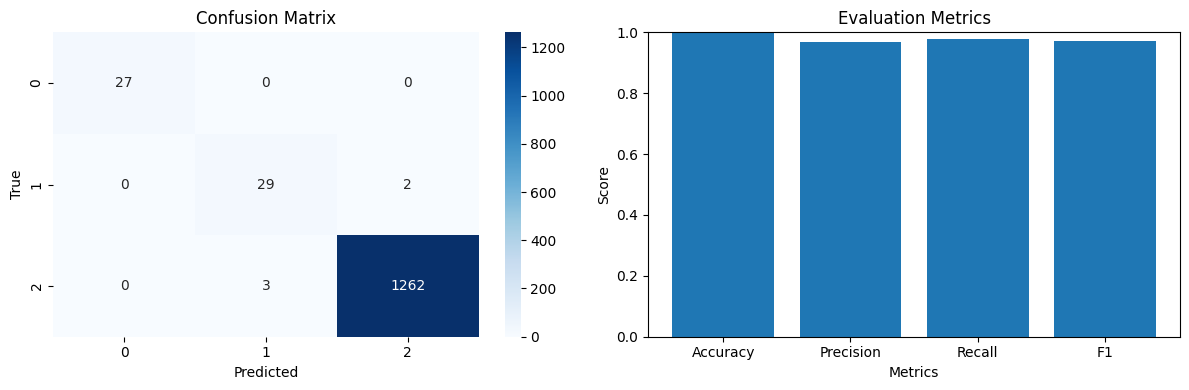

['Neural Network', 1.0, 0.97, 0.98, 0.97]

In [ ]:
y_predict = model.predict(x_test)
y_pred_classes = np.argmax(y_predict, axis=1)
accuracy = m.accuracy_score(np.argmax(y_test_class, axis=1), y_pred_classes)
precision = m.precision_score(np.argmax(y_test_class, axis=1), y_pred_classes,average='macro', pos_label='positive')
recall = m.recall_score(np.argmax(y_test_class, axis=1), y_pred_classes,average='macro', pos_label='positive')
f1 = m.f1_score(np.argmax(y_test_class, axis=1), y_pred_classes,average='macro', pos_label='positive')
print(m.classification_report(np.argmax(y_test_class, axis=1), y_pred_classes))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  
  # Vẽ confusion matrix
sns.heatmap(m.confusion_matrix(np.argmax(y_test_class, axis=1), y_pred_classes), annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_xticklabels(np.unique(np.argmax(y_test_class, axis=1)))
ax1.set_yticklabels(np.unique(np.argmax(y_test_class, axis=1)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')
ax1.set_title('Confusion Matrix')

  # Vẽ biểu đồ cột
ax2.bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])
ax2.set_ylim(0, 1)
ax2.set_xlabel('Metrics')
ax2.set_ylabel('Score')
ax2.set_title('Evaluation Metrics')

plt.tight_layout()
plt.show()


nw =['Neural Network', round(accuracy,2), round(precision,2), round(recall,2), round(f1,2)]
nw

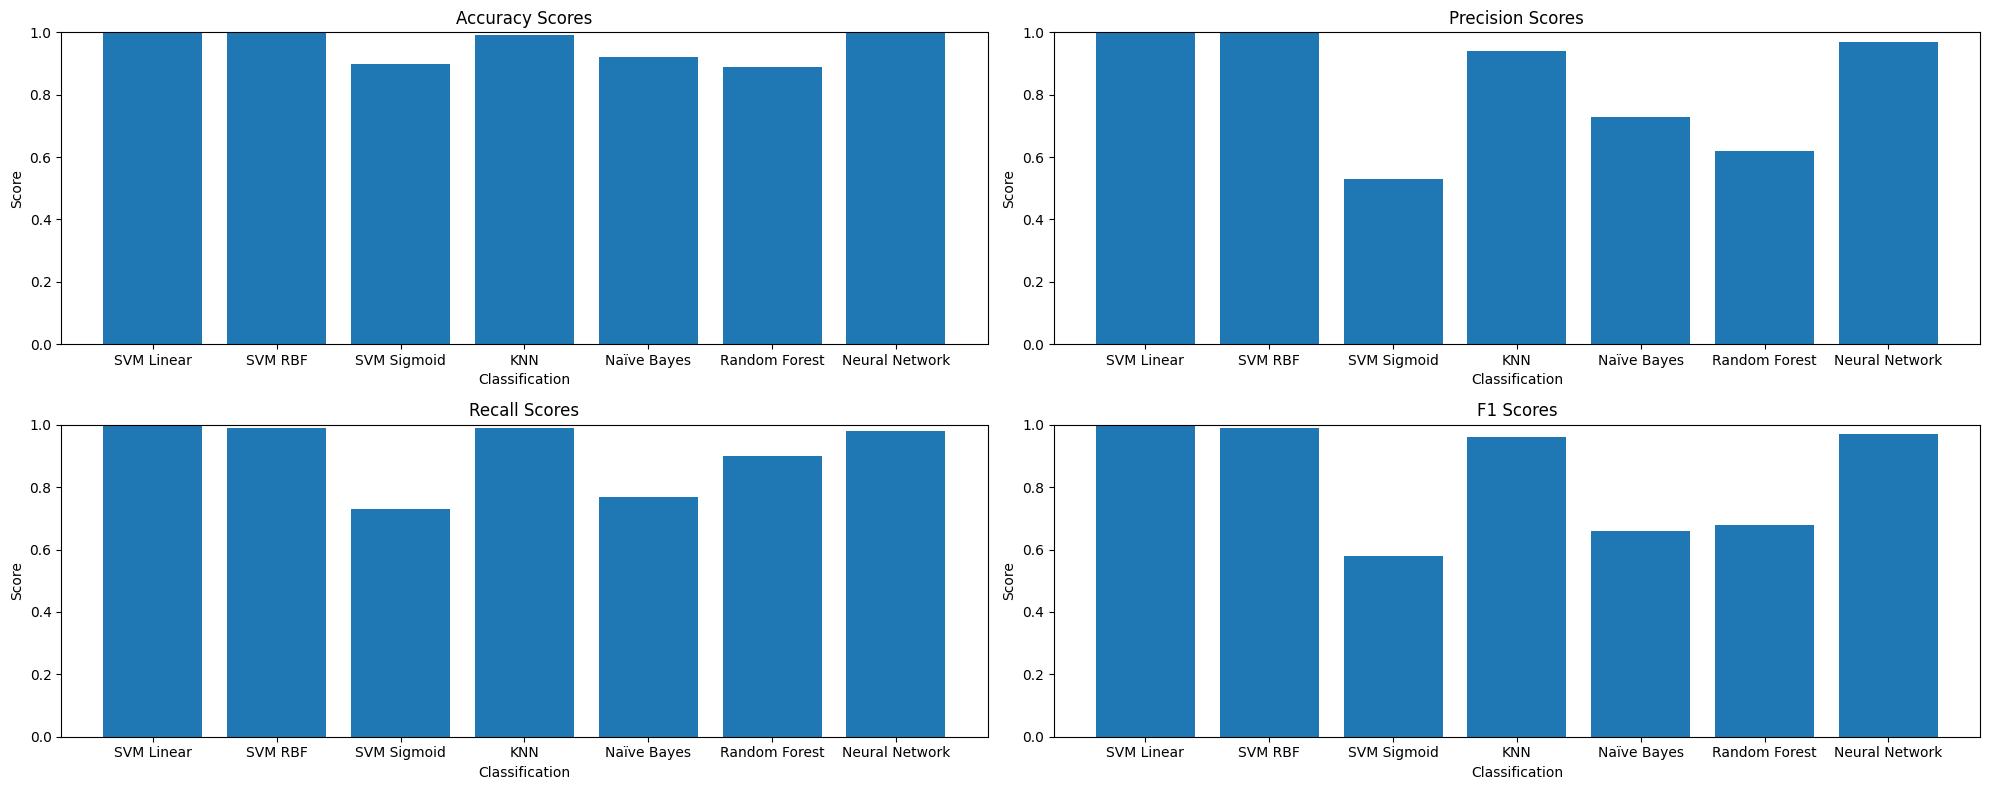

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 8))
  

x = [svm_linear[0], svm_rbf[0], svm_sigmoid[0], knn[0], nb[0], rf[0], nw[0]]
ac = [svm_linear[1], svm_rbf[1], svm_sigmoid[1], knn[1], nb[1], rf[1], nw[1]]
ps = [svm_linear[2], svm_rbf[2], svm_sigmoid[2], knn[2], nb[2], rf[2], nw[2]]
rs= [svm_linear[3], svm_rbf[3], svm_sigmoid[3], knn[3], nb[3], rf[3], nw[3]]
fs= [svm_linear[4], svm_rbf[4], svm_sigmoid[4], knn[4], nb[4], rf[4], nw[4]]
ax1.bar(x, ac)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Classification')
ax1.set_ylabel('Score')
ax1.set_title('Accuracy Scores')

ax2.bar(x, ps)
ax2.set_ylim(0, 1)
ax2.set_xlabel('Classification')
ax2.set_ylabel('Score')
ax2.set_title('Precision Scores')

ax3.bar(x, rs)
ax3.set_ylim(0, 1)
ax3.set_xlabel('Classification')
ax3.set_ylabel('Score')
ax3.set_title('Recall Scores')

ax4.bar(x, fs)
ax4.set_ylim(0, 1)
ax4.set_xlabel('Classification')
ax4.set_ylabel('Score')
ax4.set_title('F1 Scores')

plt.tight_layout()
plt.show()
